# Neural network for h->aa->bbtautau signal/background separation

# Model definition and training

## Packages

In [1]:
import ROOT
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline

from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Activation, Dense, Dropout
from keras.initializers import glorot_uniform
from keras.utils import plot_model

import kerastuner
from kerastuner import Hyperband

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc

import joblib

Welcome to JupyROOT 6.22/06


Using TensorFlow backend.


## Load root files

In [2]:
file_obs18 = ROOT.RDataFrame('mutau_tree', 'root_raw/mt18_raw/data_obs.root')
file_sig18 = ROOT.RDataFrame('mutau_tree', {'root_raw/mt18_raw/ggH_bbtt*.root', 'root_raw/mt18_raw/vbf_bbtt*.root'})
file_ZTT18 = ROOT.RDataFrame('mutau_tree', 'root_raw/mt18_raw/embedded.root')
file_TT18 = ROOT.RDataFrame('mutau_tree', 'root_raw/mt18_raw/TT*.root')

file_obs17 = ROOT.RDataFrame('mutau_tree', 'root_raw/mt17_raw/data_obs.root')
file_sig17 = ROOT.RDataFrame('mutau_tree', {'root_raw/mt17_raw/ggH_bbtt*.root', 'root_raw/mt17_raw/vbf_bbtt*.root'})
file_ZTT17 = ROOT.RDataFrame('mutau_tree', 'root_raw/mt17_raw/embedded.root')
file_TT17 = ROOT.RDataFrame('mutau_tree', 'root_raw/mt17_raw/TT*.root')

file_obs16 = ROOT.RDataFrame('mutau_tree', 'root_raw/mt16_raw/data_obs.root')
file_sig16 = ROOT.RDataFrame('mutau_tree', {'root_raw/mt16_raw/ggH_bbtt*.root', 'root_raw/mt16_raw/vbf_bbtt*.root'})
file_ZTT16 = ROOT.RDataFrame('mutau_tree', 'root_raw/mt16_raw/embedded.root')
file_TT16 = ROOT.RDataFrame('mutau_tree', 'root_raw/mt16_raw/TT*.root')

files18 = [file_obs18, file_sig18, file_ZTT18, file_TT18]
files17 = [file_obs17, file_sig17, file_ZTT17, file_TT17]
files16 = [file_obs16, file_sig16, file_ZTT16, file_TT16]

In [3]:
# 1b events
for i in range(len(files18)):
    files18[i] = files18[i].Filter('bpt_deepcsv_1>20 && bscore_deepcsv_1>0.4184 && bpt_deepcsv_2<0')
    files17[i] = files17[i].Filter('bpt_deepcsv_1>20 && bscore_deepcsv_1>0.4941 && bpt_deepcsv_2<0')
    files16[i] = files16[i].Filter('bpt_deepcsv_1>20 && bscore_deepcsv_1>0.6321 && bpt_deepcsv_2<0')

## Define some input features

In [4]:
# define 4-vectors, invariant masses and etc.
mymu = 'ROOT::Math::PtEtaPhiMVector(pt_1,eta_1,phi_1,m_1)'
mytau = 'ROOT::Math::PtEtaPhiMVector(pt_2,eta_2,phi_2,m_2)'
mymet = 'ROOT::Math::PtEtaPhiMVector(met,0,metphi,0)'
mytt = 'ROOT::Math::PtEtaPhiMVector((mymu+mytau+mymet).Pt(),(mymu+mytau+mymet).Eta(),(mymu+mytau+mymet).Phi(),m_sv)'
myb1 = 'ROOT::Math::PtEtaPhiMVector(bpt_deepcsv_1,beta_deepcsv_1,bphi_deepcsv_1,bm_deepcsv_1)'
m_btt = '(mytt+myb1).M()'
m_b1mu = '(mymu+myb1).M()'
m_b1tau = '(mytau+myb1).M()'
dR_tt = 'ROOT::Math::VectorUtil::DeltaR(mymu,mytau)'
dR_b1mu = 'ROOT::Math::VectorUtil::DeltaR(mymu,myb1)'
dR_b1tau = 'ROOT::Math::VectorUtil::DeltaR(mytau,myb1)'
dR_b1tt = 'ROOT::Math::VectorUtil::DeltaR(myb1,mytt)'
tt_pt = 'mytt.Pt()'
tt_eta = 'mytt.Eta()'

# define transverse masses mT and D_zeta
mT_mu = 'sqrt(pow(mymu.Pt()+mymet.Pt(),2)-pow(mymu.Px()+mymet.Px(),2)-pow(mymu.Py()+mymet.Py(),2))'
mT_tau = 'sqrt(pow(mytau.Pt()+mymet.Pt(),2)-pow(mytau.Px()+mymet.Px(),2)-pow(mytau.Py()+mymet.Py(),2))'
mT_b1 = 'sqrt(pow(myb1.Pt()+mymet.Pt(),2)-pow(myb1.Px()+mymet.Px(),2)-pow(myb1.Py()+mymet.Py(),2))'
norm_zeta = 'sqrt(pow(mymu.Px()/mymu.Pt()+mytau.Px()/mytau.Pt(),2)+pow(mymu.Py()/mymu.Pt()+mytau.Py()/mytau.Pt(),2))'
x_zeta = '(mymu.Px()/mymu.Pt()+mytau.Px()/mytau.Pt())/norm_zeta'
y_zeta = '(mymu.Py()/mymu.Pt()+mytau.Py()/mytau.Pt())/norm_zeta'
p_zeta_mis = 'mymet.Px()*x_zeta+mymet.Py()*y_zeta'
pzeta_vis = '(mymu.Px()+mytau.Px())*x_zeta+(mymu.Py()+mytau.Py())*y_zeta'
Dzeta = 'p_zeta_mis-0.85*pzeta_vis'

# add defined variables to dataframe
for i in range(len(files18)):
    files18[i] = files18[i].Define('mymu', mymu)\
    .Define('mytau', mytau)\
    .Define('mymet', mymet)\
    .Define('mytt', mytt)\
    .Define('myb1', myb1)\
    .Define('m_btt', m_btt)\
    .Define('m_b1mu', m_b1mu)\
    .Define('m_b1tau', m_b1tau)\
    .Define('dR_tt', dR_tt)\
    .Define('dR_b1mu', dR_b1mu)\
    .Define('dR_b1tau', dR_b1tau)\
    .Define('dR_b1tt', dR_b1tt)\
    .Define('tt_pt', tt_pt)\
    .Define('tt_eta', tt_eta)\
    .Define('mT_mu', mT_mu)\
    .Define('mT_tau', mT_tau)\
    .Define('mT_b1', mT_b1)\
    .Define('norm_zeta', norm_zeta)\
    .Define('x_zeta', x_zeta)\
    .Define('y_zeta', y_zeta)\
    .Define('p_zeta_mis', p_zeta_mis)\
    .Define('pzeta_vis', pzeta_vis)\
    .Define('Dzeta', Dzeta)
    
    files17[i] = files17[i].Define('mymu', mymu)\
    .Define('mytau', mytau)\
    .Define('mymet', mymet)\
    .Define('mytt', mytt)\
    .Define('myb1', myb1)\
    .Define('m_btt', m_btt)\
    .Define('m_b1mu', m_b1mu)\
    .Define('m_b1tau', m_b1tau)\
    .Define('dR_tt', dR_tt)\
    .Define('dR_b1mu', dR_b1mu)\
    .Define('dR_b1tau', dR_b1tau)\
    .Define('dR_b1tt', dR_b1tt)\
    .Define('tt_pt', tt_pt)\
    .Define('tt_eta', tt_eta)\
    .Define('mT_mu', mT_mu)\
    .Define('mT_tau', mT_tau)\
    .Define('mT_b1', mT_b1)\
    .Define('norm_zeta', norm_zeta)\
    .Define('x_zeta', x_zeta)\
    .Define('y_zeta', y_zeta)\
    .Define('p_zeta_mis', p_zeta_mis)\
    .Define('pzeta_vis', pzeta_vis)\
    .Define('Dzeta', Dzeta)
    
    files16[i] = files16[i].Define('mymu', mymu)\
    .Define('mytau', mytau)\
    .Define('mymet', mymet)\
    .Define('mytt', mytt)\
    .Define('myb1', myb1)\
    .Define('m_btt', m_btt)\
    .Define('m_b1mu', m_b1mu)\
    .Define('m_b1tau', m_b1tau)\
    .Define('dR_tt', dR_tt)\
    .Define('dR_b1mu', dR_b1mu)\
    .Define('dR_b1tau', dR_b1tau)\
    .Define('dR_b1tt', dR_b1tt)\
    .Define('tt_pt', tt_pt)\
    .Define('tt_eta', tt_eta)\
    .Define('mT_mu', mT_mu)\
    .Define('mT_tau', mT_tau)\
    .Define('mT_b1', mT_b1)\
    .Define('norm_zeta', norm_zeta)\
    .Define('x_zeta', x_zeta)\
    .Define('y_zeta', y_zeta)\
    .Define('p_zeta_mis', p_zeta_mis)\
    .Define('pzeta_vis', pzeta_vis)\
    .Define('Dzeta', Dzeta)

## Apply baseline selection cuts

In [5]:
######################## 2 0 1 8 ##########################
# 2018 mu+tau trigger requirements
trigger24OR27_18 = '((passMu24 && matchMu24_1 && filterMu24_1 && pt_1>25) or (passMu27 && matchMu27_1 && filterMu27_1 && pt_1>25))'#keep 25 not 28
trigger2027_18 = '(passMu20Tau27 && matchMu20Tau27_1 && filterMu20Tau27_1 && matchMu20Tau27_2 && filterMu20Tau27_2 && pt_1>21 && pt_1<25 && pt_2>32 && fabs(eta_2)<2.1)'
trigger2027HPS_18 = '(passMu20HPSTau27 && matchMu20HPSTau27_1 && filterMu20HPSTau27_1 && matchMu20HPSTau27_2 && filterMu20HPSTau27_2 && pt_1>21 && pt_1<25 && pt_2>32 && fabs(eta_2)<2.1)'
trigger24OR27_emb_18 = '((passMu24 && matchMu24_1 && pt_1>25) or (passMu27 && matchMu27_1 && pt_1>25))'#keep 25 not 28
trigger2027HPS_emb_18 = '(matchEmbFilter_Mu20Tau27_1 && matchEmbFilter_Mu20HPSTau27_2 && pt_1>21 && pt_1<25 && pt_2>32 && fabs(eta_2)<2.1)'

trigger_mc_18 = trigger24OR27_18 + str(' or ') + trigger2027HPS_18
trigger_obs_1_18 = trigger2027_18 + str(' or ') + trigger24OR27_18
trigger_obs_2_18 = trigger2027HPS_18 + str(' or ') + trigger24OR27_18
trigger_emb_18 = trigger24OR27_emb_18 + str(' or ') + trigger2027HPS_emb_18

for i in range(len(files18)):
    files18[i] = files18[i].Filter('Flag_goodVertices==0')\
    .Filter('Flag_globalSuperTightHalo2016Filter==0')\
    .Filter('Flag_HBHENoiseFilter==0')\
    .Filter('Flag_HBHENoiseIsoFilter==0')\
    .Filter('Flag_EcalDeadCellTriggerPrimitiveFilter==0')\
    .Filter('Flag_BadPFMuonFilter==0')\
    .Filter('Flag_ecalBadCalibReducedMINIAODFilter==0')\
    .Filter('pt_2>20')\
    .Filter('fabs(eta_1)<2.1 && fabs(eta_2)<2.3')\
    .Filter('iso_1<0.15')\
    .Filter('byVLooseDeepVSe_2 && byTightDeepVSmu_2')\
    .Filter('dR_tt>0.4')

files18[0] = files18[0].Filter('Flag_eeBadScFilter==0')
files18[2] = files18[2].Filter('Flag_eeBadScFilter==0')

files18[3] = files18[3].Filter('gen_match_2!=6').Filter('(gen_match_1<3 or gen_match_1==6) && gen_match_2<3')

files18[1] = files18[1].Filter('gen_match_1==4 && gen_match_2==5')#recontructed taus are gen taus
files18[1] = files18[1].Filter('m_btt<200')#reject long tail (mostly wrongly reco b jet)

files18[2] = files18[2].Filter('gen_match_2!=6').Filter('genweight<=1.0')

# triggers
obs1_18 = files18[0].Filter('run<317509').Filter(trigger_obs_1_18)
obs2_18 = files18[0].Filter('run>=317509').Filter(trigger_obs_2_18)
files18[1] = files18[1].Filter(trigger_mc_18)
files18[2] = files18[2].Filter(trigger_emb_18)
files18[3] = files18[3].Filter(trigger_mc_18)

# QCD region
qcd1_18 = obs1_18.Filter('q_1*q_2>0').Filter('byMediumDeepVSjet_2==0')
qcd2_18 = obs2_18.Filter('q_1*q_2>0').Filter('byMediumDeepVSjet_2==0')

# signal region
for i in range(1,len(files18)):
    files18[i] = files18[i].Filter('q_1*q_2<0')\
    .Filter('byMediumDeepVSjet_2')

######################## 2 0 1 7 ##########################
# 2017 mu+tau trigger requirements
trigger24OR27_17 = '((passMu24 && matchMu24_1 && filterMu24_1 && pt_1>25) or (passMu27 && matchMu27_1 && filterMu27_1 && pt_1>25))'#keep 25 not 28
trigger2027_17 = '(passMu20Tau27 && matchMu20Tau27_1 && filterMu20Tau27_1 && matchMu20Tau27_2 && filterMu20Tau27_2 && pt_1>21 && pt_1<25 && pt_2>32 && fabs(eta_2)<2.1)'
trigger24OR27_emb_17 = '((passMu24 && matchMu24_1 && pt_1>25) or (passMu27 && matchMu27_1 && pt_1>25))'#keep 25 not 28
trigger2027_emb_17 = '(matchEmbFilter_Mu20Tau27_2017_1 && matchEmbFilter_Mu20Tau27_2 && pt_1>21 && pt_1<25 && pt_2>32 && fabs(eta_2)<2.1)'

trigger_mc_obs_17 = trigger24OR27_17 + str(' or ') + trigger2027_17
trigger_emb_17 = trigger24OR27_emb_17 + str(' or ') + trigger2027_emb_17

for i in range(len(files17)):
    files17[i] = files17[i].Filter('Flag_goodVertices==0')\
    .Filter('Flag_globalSuperTightHalo2016Filter==0')\
    .Filter('Flag_HBHENoiseFilter==0')\
    .Filter('Flag_HBHENoiseIsoFilter==0')\
    .Filter('Flag_EcalDeadCellTriggerPrimitiveFilter==0')\
    .Filter('Flag_BadPFMuonFilter==0')\
    .Filter('Flag_ecalBadCalibReducedMINIAODFilter==0')\
    .Filter('pt_2>20')\
    .Filter('fabs(eta_1)<2.1 && fabs(eta_2)<2.3')\
    .Filter('iso_1<0.15')\
    .Filter('byVLooseDeepVSe_2 && byTightDeepVSmu_2')\
    .Filter('dR_tt>0.4')

files17[0] = files17[0].Filter('Flag_eeBadScFilter==0')
files17[2] = files17[2].Filter('Flag_eeBadScFilter==0')

files17[3] = files17[3].Filter('gen_match_2!=6').Filter('(gen_match_1<3 or gen_match_1==6) && gen_match_2<3')

files17[1] = files17[1].Filter('gen_match_1==4 && gen_match_2==5')#recontructed taus are gen taus
files17[1] = files17[1].Filter('m_btt<200')#reject long tail (mostly wrongly reco b jet)

files17[2] = files17[2].Filter('gen_match_2!=6').Filter('genweight<=1.0')

# triggers
files17[0] = files17[0].Filter(trigger_mc_obs_17)
files17[1] = files17[1].Filter(trigger_mc_obs_17)
files17[2] = files17[2].Filter(trigger_emb_17)
files17[3] = files17[3].Filter(trigger_mc_obs_17)

# QCD region
qcd_17 = files17[0].Filter('q_1*q_2>0').Filter('byMediumDeepVSjet_2==0')

# signal region
for i in range(1,len(files17)):
    files17[i] = files17[i].Filter('q_1*q_2<0')\
    .Filter('byMediumDeepVSjet_2')

######################## 2 0 1 6 ##########################
# 2016 mu+tau trigger requirements
trigger22_16 = '((passMu22eta2p1 && matchMu22eta2p1_1 && filterMu22eta2p1_1 && pt_1>23) or (passTkMu22eta2p1 && matchTkMu22eta2p1_1 && filterTkMu22eta2p1_1 && pt_1>23) or (passMu22 && matchMu22_1 && filterMu22_1 && pt_1>23) or (passTkMu22 && matchTkMu22_1 && filterTkMu22_1 && pt_1>23))'
trigger1920_16 = '((passMu19Tau20 && matchMu19Tau20_1 && matchMu19Tau20_2 && filterMu19Tau20_1 && filterMu19Tau20_2 && pt_1>20 && pt_1<23 && pt_2>25 && fabs(eta_2)<2.1) or (passMu19Tau20SingleL1 && matchMu19Tau20SingleL1_1 && matchMu19Tau20SingleL1_2 && filterMu19Tau20SingleL1_1 && filterMu19Tau20SingleL1_2 && pt_1>20 && pt_1<23 && pt_2>25 && fabs(eta_2)<2.1))'

trigger_all_16 = trigger22_16 + str(' or ') + trigger1920_16

for i in range(len(files16)):
    files16[i] = files16[i].Filter('Flag_goodVertices==0')\
    .Filter('Flag_globalSuperTightHalo2016Filter==0')\
    .Filter('Flag_HBHENoiseFilter==0')\
    .Filter('Flag_HBHENoiseIsoFilter==0')\
    .Filter('Flag_EcalDeadCellTriggerPrimitiveFilter==0')\
    .Filter('Flag_BadPFMuonFilter==0')\
    .Filter('pt_2>20')\
    .Filter('fabs(eta_1)<2.1 && fabs(eta_2)<2.3')\
    .Filter('iso_1<0.15')\
    .Filter('byVLooseDeepVSe_2 && byTightDeepVSmu_2')\
    .Filter('dR_tt>0.4')

files16[0] = files16[0].Filter('Flag_eeBadScFilter==0')
files16[2] = files16[2].Filter('Flag_eeBadScFilter==0')

files16[3] = files16[3].Filter('gen_match_2!=6').Filter('(gen_match_1<3 or gen_match_1==6) && gen_match_2<3')

files16[1] = files16[1].Filter('gen_match_1==4 && gen_match_2==5')#recontructed taus are gen taus
files16[1] = files16[1].Filter('m_btt<200')#reject long tail (mostly wrongly reco b jet)

files16[2] = files16[2].Filter('gen_match_2!=6').Filter('genweight<=1.0')

# triggers
files16[0] = files16[0].Filter(trigger_all_16)
files16[1] = files16[1].Filter(trigger_all_16)
files16[2] = files16[2].Filter(trigger_all_16)
files16[3] = files16[3].Filter(trigger_all_16)

# QCD region
qcd_16 = files16[0].Filter('q_1*q_2>0').Filter('byMediumDeepVSjet_2==0')

# signal region
for i in range(1,len(files16)):
    files16[i] = files16[i].Filter('q_1*q_2<0')\
    .Filter('byMediumDeepVSjet_2')

# [0]=obs, [1]=sig, [2]=embedded, [3]=ttbar

## Select all input features and save into pandas DataFrame

In [6]:
# list of feature variables
###### for 1b events
feature_list = ['pt_1', 'm_btt', 'm_b1mu', 'm_b1tau',\
                'dR_tt', 'dR_b1mu', 'dR_b1tau', 'dR_b1tt',\
                'tt_pt', 'tt_eta', 'mT_mu', 'mT_tau', 'mT_b1', 'Dzeta',\
                'bpt_deepcsv_1', 'njets']

# convert root RDataFrame into pandas DataFrame, saving only the features as columns
for i in range(1,len(files18)):
    files18[i] = pd.DataFrame(files18[i].AsNumpy(feature_list))
    files17[i] = pd.DataFrame(files17[i].AsNumpy(feature_list))
    files16[i] = pd.DataFrame(files16[i].AsNumpy(feature_list))
qcd1_18 = pd.DataFrame(qcd1_18.AsNumpy(feature_list))
qcd2_18 = pd.DataFrame(qcd2_18.AsNumpy(feature_list))
qcd_17 = pd.DataFrame(qcd_17.AsNumpy(feature_list))
qcd_16 = pd.DataFrame(qcd_16.AsNumpy(feature_list))

print('sig18.shape  : ' + str(files18[1].shape))
print('ZTT18.shape  : ' + str(files18[2].shape))
print('TT18.shape   : ' + str(files18[3].shape))
print('qcd18_1.shape: ' + str(qcd1_18.shape))
print('qcd18_2.shape: ' + str(qcd2_18.shape))
print('\nsig17.shape  : ' + str(files17[1].shape))
print('ZTT17.shape  : ' + str(files17[2].shape))
print('TT17.shape   : ' + str(files17[3].shape))
print('qcd17.shape  : ' + str(qcd_17.shape))
print('\nsig16.shape  : ' + str(files16[1].shape))
print('ZTT16.shape  : ' + str(files16[2].shape))
print('TT16.shape   : ' + str(files16[3].shape))
print('qcd16.shape  : ' + str(qcd_16.shape))

sig_allyears = [files18[1], files17[1], files16[1]]
ZTT_allyears = [files18[2], files17[2], files16[2]]
TT_allyears = [files18[3], files17[3], files16[3]]
qcd_allyears = [qcd1_18, qcd2_18, qcd_17, qcd_16]

sig_allyears = pd.concat(sig_allyears)
ZTT_allyears = pd.concat(ZTT_allyears)
TT_allyears = pd.concat(TT_allyears)
qcd_allyears = pd.concat(qcd_allyears)

# tag MC signal events as class 1
sig_allyears['label'] = np.ones((sig_allyears.shape[0], 1))

# tag MC background events as class 0
ZTT_allyears['label'] = np.zeros((ZTT_allyears.shape[0], 1))
TT_allyears['label'] = np.zeros((TT_allyears.shape[0],1))
qcd_allyears['label'] = np.zeros((qcd_allyears.shape[0], 1))

print('\nsig_allyears.shape: ' + str(sig_allyears.shape))
print('ZTT_allyears.shape: ' + str(ZTT_allyears.shape))
print('TT_allyears.shape : ' + str(TT_allyears.shape))
print('qcd_allyears.shape: ' + str(qcd_allyears.shape))

sig18.shape  : (17561, 16)
ZTT18.shape  : (158696, 16)
TT18.shape   : (11813, 16)
qcd18_1.shape: (61945, 16)
qcd18_2.shape: (141933, 16)

sig17.shape  : (16929, 16)
ZTT17.shape  : (91481, 16)
TT17.shape   : (1471, 16)
qcd17.shape  : (123221, 16)

sig16.shape  : (23453, 16)
ZTT16.shape  : (73915, 16)
TT16.shape   : (1047, 16)
qcd16.shape  : (89263, 16)

sig_allyears.shape: (57943, 17)
ZTT_allyears.shape: (324092, 17)
TT_allyears.shape : (14331, 17)
qcd_allyears.shape: (416362, 17)


## Split into MC/data

In [7]:
# reduce class 0 sample size for balanced training
ZTT_allyears = ZTT_allyears.sample(n = 18612, random_state = 20)#32.1%
TT_allyears = TT_allyears.sample(n = 14331, random_state = 20)#24.7%
qcd_allyears = qcd_allyears.sample(n = 25000, random_state = 20)#43.1%

# collect all MC as one dataframe, separated from another datafream for observed data
df_bkg = [ZTT_allyears, TT_allyears, qcd_allyears]
df_bkg = pd.concat(df_bkg)

df_MC = [sig_allyears, ZTT_allyears, TT_allyears, qcd_allyears]
df_MC = pd.concat(df_MC)

#print('\nObserved dataframe: \n' + str(df_obs))
print('\nMC dataframe: \n' + str(df_MC))


MC dataframe: 
              pt_1       m_btt      m_b1mu     m_b1tau     dR_tt   dR_b1mu  \
0        27.640627  105.860710   86.127964   88.114555  0.402234  2.820982   
1        29.985403   86.127265   82.287163   67.355697  0.402287  3.155046   
2        28.194452   88.469771   75.350343   65.025970  0.426936  2.842973   
3        26.203440  170.696067   74.096257   70.580542  0.418958  2.979965   
4        25.275053   70.564612   57.562529   64.946026  0.404176  3.026494   
...            ...         ...         ...         ...       ...       ...   
107682  120.088005  658.512092  263.470385  328.113916  3.094226  3.026713   
28547    54.696835   88.601118   94.398499   62.840983  0.854694  3.062224   
34446    38.588085  213.784170  127.391958   92.229180  1.655266  2.778983   
84362    70.530388  351.890780  236.502652  109.658532  2.122919  3.335880   
75331    34.609818  234.426355   93.606251  124.823618  2.926085  3.089512   

        dR_b1tau   dR_b1tt       tt_pt    tt_et

## Compare input feature distributions between sig and bkg

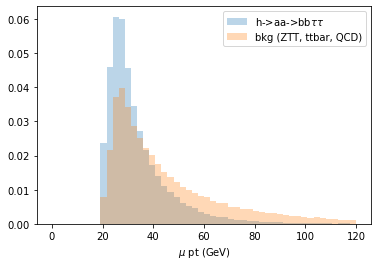

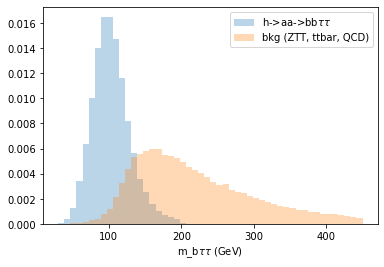

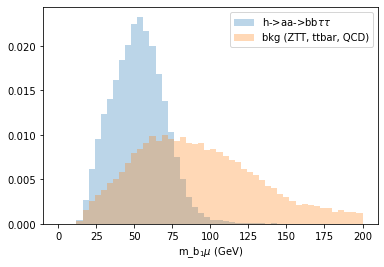

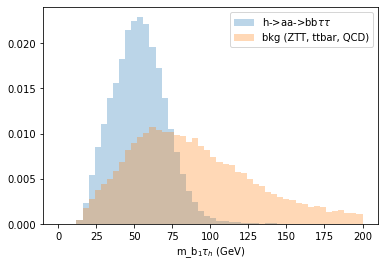

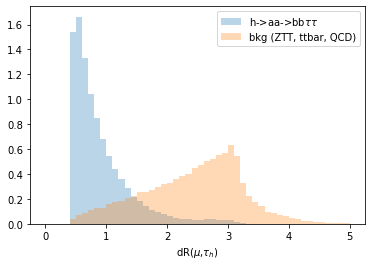

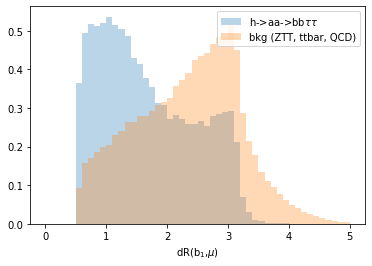

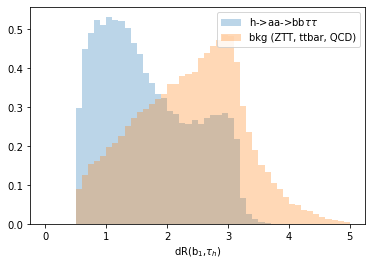

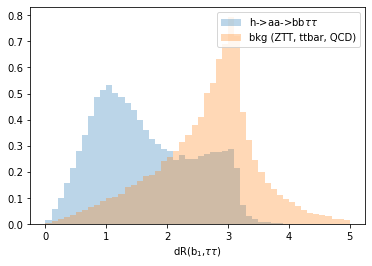

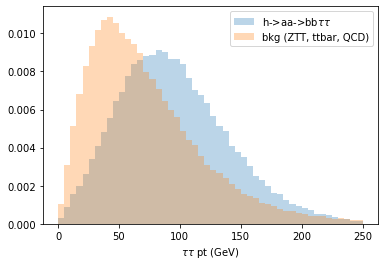

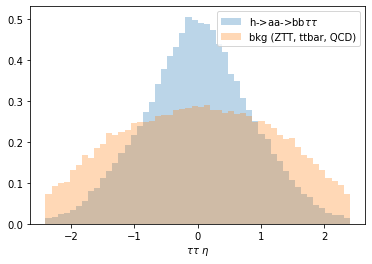

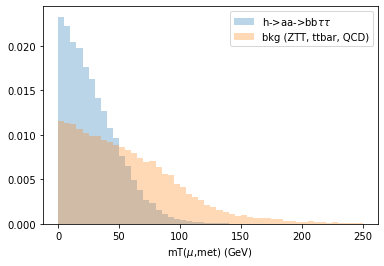

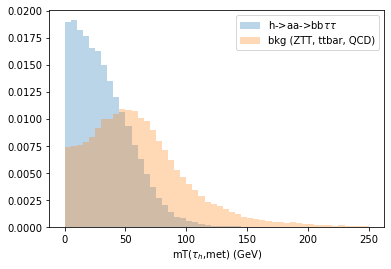

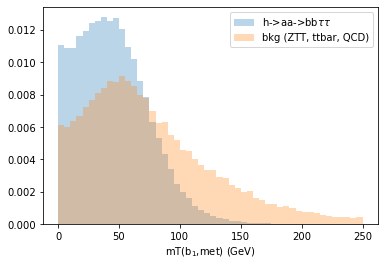

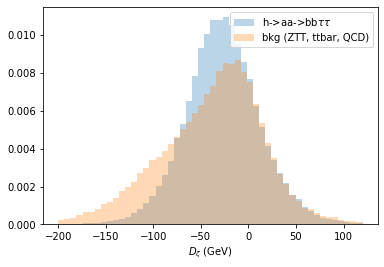

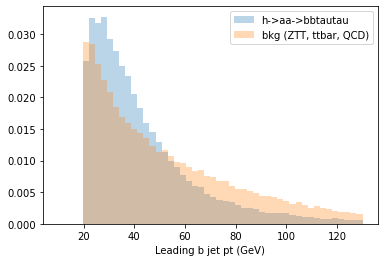

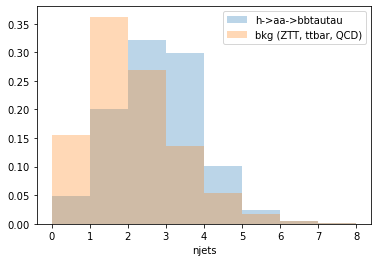

In [8]:
pyplot.hist(sig_allyears['pt_1'], density = 1, range = (0,120), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['pt_1'], density = 1, range = (0,120), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['pt_1'], density = 1, range = (0,120), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['pt_1'], density = 1, range = (0,120), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['pt_1'], density = 1, range = (0,120), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('$\mu$ pt (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['m_btt'], density = 1, range = (30,450), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['m_btt'], density = 1, range = (30,450), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['m_btt'], density = 1, range = (30,450), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['m_btt'], density = 1, range = (30,450), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['m_btt'], density = 1, range = (30,450), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_b$\\tau\\tau$ (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['m_b1mu'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['m_b1mu'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['m_b1mu'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['m_b1mu'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['m_b1mu'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_b$_1$$\mu$ (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['m_b1tau'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['m_b1tau'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['m_b1tau'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['m_b1tau'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['m_b1tau'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_b$_1$$\\tau_h$ (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR($\mu$,$\\tau_h$)')
pyplot.show()

pyplot.hist(sig_allyears['dR_b1mu'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dR_b1mu'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['dR_b1mu'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['dR_b1mu'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['dR_b1mu'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b$_1$,$\mu$)')
pyplot.show()

pyplot.hist(sig_allyears['dR_b1tau'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dR_b1tau'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['dR_b1tau'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['dR_b1tau'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['dR_b1tau'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b$_1$,$\\tau_h$)')
pyplot.show()

pyplot.hist(sig_allyears['dR_b1tt'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dR_b1tt'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['dR_b1tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['dR_b1tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['dR_b1tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b$_1$,$\\tau\\tau$)')
pyplot.show()

pyplot.hist(sig_allyears['tt_pt'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['tt_pt'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['tt_pt'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['tt_pt'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['tt_pt'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('$\\tau\\tau$ pt (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['tt_eta'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['tt_eta'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['tt_eta'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['tt_eta'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['tt_eta'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('$\\tau\\tau$ $\eta$')
pyplot.show()

pyplot.hist(sig_allyears['mT_mu'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['mT_mu'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['mT_mu'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['mT_mu'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['mT_mu'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('mT($\mu$,met) (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['mT_tau'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['mT_tau'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['mT_tau'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['mT_tau'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['mT_tau'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('mT($\\tau_h$,met) (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['mT_b1'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['mT_b1'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['mT_b1'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['mT_b1'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['mT_b1'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('mT(b$_1$,met) (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['Dzeta'], density = 1, range = (-200,120), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['Dzeta'], density = 1, range = (-200,120), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['Dzeta'], density = 1, range = (-200,120), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['Dzeta'], density = 1, range = (-200,120), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['Dzeta'], density = 1, range = (-200,120), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('$D_\zeta$ (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['bpt_deepcsv_1'], density = 1, range = (10,130), bins = 50, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.hist(df_bkg['bpt_deepcsv_1'], density = 1, range = (10,130), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['bpt_deepcsv_1'], density = 1, range = (10,130), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['bpt_deepcsv_1'], density = 1, range = (10,130), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['bpt_deepcsv_1'], density = 1, range = (10,130), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('Leading b jet pt (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['njets'], density = 1, range = (0,8), bins = 8, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.hist(df_bkg['njets'], density = 1, range = (0,8), bins = 8, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['njets'], density = 1, range = (0,8), bins = 8, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['njets'], density = 1, range = (0,8), bins = 8, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['njets'], density = 1, range = (0,8), bins = 8, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('njets')
pyplot.show()

## Input data pre-processing

In [9]:
# convert to numpy arrays
dataset = df_MC.values
X = dataset[:,0:(dataset.shape[1]-1)]
Y = dataset[:,dataset.shape[1]-1]
Y = Y.reshape(Y.shape[0],1)

#dataset_obs = df_obs.values
#X_obs = dataset_obs[:,0:(dataset_obs.shape[1])]

# give train/val/test partition ratios
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 1 - train_ratio - val_ratio

# randomly partition data set into train/val/test sets with given ratios
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size = test_ratio, random_state=15)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size = val_ratio/(val_ratio+train_ratio), random_state=15)

# standardize feature variables
# only based on means and stds in train_val set, should apply this only scaler to all other sets
# think of the transformation in phase space
scaler = StandardScaler().fit(X_train_val)
X_train_val = scaler.transform(X_train_val)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
#X_obs = scaler.transform(X_obs)

# print input data shapes
print("\nPartition the data set into train/val/test: %.2f/%.2f/%.2f" % (train_ratio, val_ratio, test_ratio))
print("X_train.shape: " + str(X_train.shape))
print("Y_train.shape: " + str(Y_train.shape))
print("X_val.shape: " + str(X_val.shape))
print("Y_val.shape: " + str(Y_val.shape))
print("X_test.shape: " + str(X_test.shape))
print("Y_test.shape: " + str(Y_test.shape))
#print("\nX_obs.shape: " + str(X_obs.shape))

# print ratio of signal/background examples in each set
train_sig = np.count_nonzero(Y_train)
train_bkg = np.count_nonzero(Y_train == 0)
train_sig_perc = 100*train_sig/(train_sig+train_bkg)
train_bkg_perc = 100*train_bkg/(train_sig+train_bkg)
val_sig = np.count_nonzero(Y_val)
val_bkg = np.count_nonzero(Y_val == 0)
val_sig_perc = 100*val_sig/(val_sig+val_bkg)
val_bkg_perc = 100*val_bkg/(val_sig+val_bkg)
test_sig = np.count_nonzero(Y_test)
test_bkg = np.count_nonzero(Y_test == 0)
test_sig_perc = 100*test_sig/(test_sig+test_bkg)
test_bkg_perc = 100*test_bkg/(test_sig+test_bkg)

total_sig = train_sig + val_sig + test_sig
total_bkg = train_bkg + val_bkg + test_bkg
total_sig_perc = 100*total_sig/(total_sig+total_bkg)
total_bkg_perc = 100*total_bkg/(total_sig+total_bkg)
print("\nTotal number of sig/bkg examples: %d/%d (%.2f%%/%.2f%%)" % (total_sig, total_bkg, total_sig_perc, total_bkg_perc))

print("\nNumber of sig/bkg examples in each set:")
print("train : %d/%d (%.1f%%/%.1f%%)" % (train_sig, train_bkg, train_sig_perc, train_bkg_perc))
print("val   : %d/%d (%.1f%%/%.1f%%)" % (val_sig, val_bkg, val_sig_perc, val_bkg_perc))
print("test  : %d/%d (%.1f%%/%.1f%%)" % (test_sig, test_bkg, test_sig_perc, test_bkg_perc))


Partition the data set into train/val/test: 0.60/0.20/0.20
X_train.shape: (69531, 16)
Y_train.shape: (69531, 1)
X_val.shape: (23177, 16)
Y_val.shape: (23177, 1)
X_test.shape: (23178, 16)
Y_test.shape: (23178, 1)

Total number of sig/bkg examples: 57943/57943 (50.00%/50.00%)

Number of sig/bkg examples in each set:
train : 34732/34799 (50.0%/50.0%)
val   : 11655/11522 (50.3%/49.7%)
test  : 11556/11622 (49.9%/50.1%)


## DNN Hyperparameters searching

In [10]:
# define model for the search
def hypermodel(hp):
    hp_model = keras.Sequential()
    hp_model.add(keras.layers.Input(shape = (X.shape[1],)))
    
    hp_model.add(keras.layers.Dense(units = hp.Int('units_1',
                                                   min_value = 20,
                                                   max_value = 60,
                                                   step = 2),
                                    activation = 'relu',
                                    kernel_initializer = glorot_uniform(seed=1)))
    
    hp_model.add(keras.layers.Dropout(rate = hp.Float('rate_1',
                                                      min_value = 0.2,
                                                      max_value = 0.5,
                                                      default = 0.2,
                                                      step = 0.1),
                                      seed = 10))
    
    hp_model.add(keras.layers.Dense(units = hp.Int('units_2',
                                                   min_value = 20,
                                                   max_value = 60,
                                                   step = 2),
                                    activation = 'relu',
                                    kernel_initializer = glorot_uniform(seed=1)))
    
    hp_model.add(keras.layers.Dropout(rate = hp.Float('rate_2',
                                                      min_value = 0.2,
                                                      max_value = 0.5,
                                                      default = 0.2,
                                                      step = 0.1),
                                      seed = 10))

    hp_model.add(keras.layers.Dense(units = 1, activation = 'sigmoid', kernel_initializer = glorot_uniform(seed=1)))
    hp_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return hp_model

In [11]:
# define tuner model
tuner = Hyperband(hypermodel,
                  objective = 'val_accuracy',
                  max_epochs = 20,
                  factor = 3, #number of models to train in a bracket = 1+log_factor(max_epochs)
                  hyperband_iterations = 1, #number of times to iterate over the full Hyperband algorithm
                  seed = 10,
                  directory = 'hypertuning',
                  project_name = 'tune',
                  overwrite = True)

2021-02-27 18:58:43.843016: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2021-02-27 18:58:43.843336: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


In [12]:
# run the search
tuner.search(X_train, Y_train, epochs = 20, validation_data = (X_val,Y_val), batch_size = 256)

Train on 69531 samples, validate on 23177 samples
Epoch 1/3
69531/69531 [==============================] - ETA: 3:05 - loss: 0.7084 - accuracy: 0.50 - ETA: 21s - loss: 0.6659 - accuracy: 0.5851 - ETA: 11s - loss: 0.6172 - accuracy: 0.651 - ETA: 8s - loss: 0.5769 - accuracy: 0.700 - ETA: 6s - loss: 0.5393 - accuracy: 0.73 - ETA: 5s - loss: 0.5004 - accuracy: 0.76 - ETA: 4s - loss: 0.4723 - accuracy: 0.78 - ETA: 3s - loss: 0.4456 - accuracy: 0.80 - ETA: 3s - loss: 0.4241 - accuracy: 0.81 - ETA: 3s - loss: 0.4016 - accuracy: 0.82 - ETA: 2s - loss: 0.3849 - accuracy: 0.83 - ETA: 2s - loss: 0.3695 - accuracy: 0.84 - ETA: 2s - loss: 0.3550 - accuracy: 0.84 - ETA: 2s - loss: 0.3417 - accuracy: 0.85 - ETA: 1s - loss: 0.3313 - accuracy: 0.86 - ETA: 1s - loss: 0.3207 - accuracy: 0.86 - ETA: 1s - loss: 0.3121 - accuracy: 0.87 - ETA: 1s - loss: 0.3034 - accuracy: 0.87 - ETA: 1s - loss: 0.2953 - accuracy: 0.87 - ETA: 1s - loss: 0.2889 - accuracy: 0.88 - ETA: 1s - loss: 0.2819 - accuracy: 0.88 - ETA

Train on 69531 samples, validate on 23177 samples
Epoch 1/3
69531/69531 [==============================] - ETA: 2:17 - loss: 0.6660 - accuracy: 0.57 - ETA: 14s - loss: 0.6362 - accuracy: 0.6137 - ETA: 8s - loss: 0.6194 - accuracy: 0.635 - ETA: 5s - loss: 0.5978 - accuracy: 0.66 - ETA: 4s - loss: 0.5795 - accuracy: 0.68 - ETA: 3s - loss: 0.5580 - accuracy: 0.70 - ETA: 3s - loss: 0.5399 - accuracy: 0.72 - ETA: 2s - loss: 0.5244 - accuracy: 0.73 - ETA: 2s - loss: 0.5043 - accuracy: 0.75 - ETA: 2s - loss: 0.4873 - accuracy: 0.76 - ETA: 2s - loss: 0.4699 - accuracy: 0.77 - ETA: 2s - loss: 0.4640 - accuracy: 0.77 - ETA: 1s - loss: 0.4475 - accuracy: 0.79 - ETA: 1s - loss: 0.4342 - accuracy: 0.79 - ETA: 1s - loss: 0.4211 - accuracy: 0.80 - ETA: 1s - loss: 0.4103 - accuracy: 0.81 - ETA: 1s - loss: 0.4000 - accuracy: 0.81 - ETA: 1s - loss: 0.3881 - accuracy: 0.82 - ETA: 1s - loss: 0.3786 - accuracy: 0.83 - ETA: 0s - loss: 0.3697 - accuracy: 0.83 - ETA: 0s - loss: 0.3621 - accuracy: 0.84 - ETA: 

Train on 69531 samples, validate on 23177 samples
Epoch 1/3
69531/69531 [==============================] - ETA: 2:21 - loss: 0.7910 - accuracy: 0.38 - ETA: 16s - loss: 0.7036 - accuracy: 0.4714 - ETA: 9s - loss: 0.6647 - accuracy: 0.525 - ETA: 6s - loss: 0.6294 - accuracy: 0.58 - ETA: 5s - loss: 0.5970 - accuracy: 0.63 - ETA: 4s - loss: 0.5669 - accuracy: 0.67 - ETA: 3s - loss: 0.5421 - accuracy: 0.69 - ETA: 3s - loss: 0.5204 - accuracy: 0.72 - ETA: 3s - loss: 0.5009 - accuracy: 0.73 - ETA: 2s - loss: 0.4809 - accuracy: 0.75 - ETA: 2s - loss: 0.4630 - accuracy: 0.76 - ETA: 2s - loss: 0.4451 - accuracy: 0.77 - ETA: 2s - loss: 0.4314 - accuracy: 0.78 - ETA: 2s - loss: 0.4176 - accuracy: 0.79 - ETA: 1s - loss: 0.4036 - accuracy: 0.80 - ETA: 1s - loss: 0.3920 - accuracy: 0.81 - ETA: 1s - loss: 0.3827 - accuracy: 0.81 - ETA: 1s - loss: 0.3720 - accuracy: 0.82 - ETA: 1s - loss: 0.3643 - accuracy: 0.82 - ETA: 1s - loss: 0.3554 - accuracy: 0.83 - ETA: 1s - loss: 0.3460 - accuracy: 0.83 - ETA: 

Train on 69531 samples, validate on 23177 samples
Epoch 1/3
69531/69531 [==============================] - ETA: 2:16 - loss: 0.6951 - accuracy: 0.50 - ETA: 16s - loss: 0.6395 - accuracy: 0.6211 - ETA: 9s - loss: 0.5944 - accuracy: 0.669 - ETA: 7s - loss: 0.5515 - accuracy: 0.71 - ETA: 5s - loss: 0.5177 - accuracy: 0.74 - ETA: 4s - loss: 0.4839 - accuracy: 0.77 - ETA: 4s - loss: 0.4584 - accuracy: 0.78 - ETA: 3s - loss: 0.4341 - accuracy: 0.80 - ETA: 3s - loss: 0.4158 - accuracy: 0.81 - ETA: 3s - loss: 0.3997 - accuracy: 0.82 - ETA: 2s - loss: 0.3870 - accuracy: 0.82 - ETA: 2s - loss: 0.3716 - accuracy: 0.83 - ETA: 2s - loss: 0.3581 - accuracy: 0.84 - ETA: 2s - loss: 0.3471 - accuracy: 0.85 - ETA: 2s - loss: 0.3358 - accuracy: 0.85 - ETA: 1s - loss: 0.3262 - accuracy: 0.86 - ETA: 1s - loss: 0.3183 - accuracy: 0.86 - ETA: 1s - loss: 0.3112 - accuracy: 0.86 - ETA: 1s - loss: 0.3042 - accuracy: 0.87 - ETA: 1s - loss: 0.2966 - accuracy: 0.87 - ETA: 1s - loss: 0.2927 - accuracy: 0.87 - ETA: 

Train on 69531 samples, validate on 23177 samples
Epoch 1/3
69531/69531 [==============================] - ETA: 2:17 - loss: 0.7313 - accuracy: 0.50 - ETA: 16s - loss: 0.6979 - accuracy: 0.5473 - ETA: 9s - loss: 0.6538 - accuracy: 0.603 - ETA: 6s - loss: 0.6197 - accuracy: 0.64 - ETA: 5s - loss: 0.5859 - accuracy: 0.68 - ETA: 4s - loss: 0.5584 - accuracy: 0.71 - ETA: 3s - loss: 0.5345 - accuracy: 0.73 - ETA: 3s - loss: 0.5084 - accuracy: 0.75 - ETA: 3s - loss: 0.4852 - accuracy: 0.76 - ETA: 2s - loss: 0.4649 - accuracy: 0.78 - ETA: 2s - loss: 0.4462 - accuracy: 0.79 - ETA: 2s - loss: 0.4326 - accuracy: 0.80 - ETA: 2s - loss: 0.4145 - accuracy: 0.81 - ETA: 1s - loss: 0.3978 - accuracy: 0.82 - ETA: 1s - loss: 0.3844 - accuracy: 0.82 - ETA: 1s - loss: 0.3712 - accuracy: 0.83 - ETA: 1s - loss: 0.3602 - accuracy: 0.84 - ETA: 1s - loss: 0.3504 - accuracy: 0.84 - ETA: 1s - loss: 0.3413 - accuracy: 0.85 - ETA: 1s - loss: 0.3337 - accuracy: 0.85 - ETA: 1s - loss: 0.3272 - accuracy: 0.86 - ETA: 

Train on 69531 samples, validate on 23177 samples
Epoch 1/3
69531/69531 [==============================] - ETA: 2:17 - loss: 0.8113 - accuracy: 0.55 - ETA: 14s - loss: 0.7077 - accuracy: 0.5898 - ETA: 8s - loss: 0.6596 - accuracy: 0.632 - ETA: 5s - loss: 0.6083 - accuracy: 0.68 - ETA: 4s - loss: 0.5630 - accuracy: 0.71 - ETA: 3s - loss: 0.5275 - accuracy: 0.74 - ETA: 3s - loss: 0.4959 - accuracy: 0.76 - ETA: 2s - loss: 0.4692 - accuracy: 0.78 - ETA: 2s - loss: 0.4469 - accuracy: 0.79 - ETA: 2s - loss: 0.4270 - accuracy: 0.81 - ETA: 2s - loss: 0.4083 - accuracy: 0.82 - ETA: 1s - loss: 0.3933 - accuracy: 0.82 - ETA: 1s - loss: 0.3781 - accuracy: 0.83 - ETA: 1s - loss: 0.3659 - accuracy: 0.84 - ETA: 1s - loss: 0.3542 - accuracy: 0.85 - ETA: 1s - loss: 0.3424 - accuracy: 0.85 - ETA: 1s - loss: 0.3318 - accuracy: 0.86 - ETA: 1s - loss: 0.3241 - accuracy: 0.86 - ETA: 1s - loss: 0.3149 - accuracy: 0.87 - ETA: 0s - loss: 0.3070 - accuracy: 0.87 - ETA: 0s - loss: 0.2999 - accuracy: 0.87 - ETA: 

Train on 69531 samples, validate on 23177 samples
Epoch 1/3
69531/69531 [==============================] - ETA: 2:17 - loss: 0.6969 - accuracy: 0.51 - ETA: 14s - loss: 0.6549 - accuracy: 0.5945 - ETA: 8s - loss: 0.6212 - accuracy: 0.640 - ETA: 6s - loss: 0.5868 - accuracy: 0.68 - ETA: 5s - loss: 0.5577 - accuracy: 0.71 - ETA: 4s - loss: 0.5299 - accuracy: 0.74 - ETA: 3s - loss: 0.5036 - accuracy: 0.76 - ETA: 3s - loss: 0.4794 - accuracy: 0.78 - ETA: 2s - loss: 0.4593 - accuracy: 0.79 - ETA: 2s - loss: 0.4387 - accuracy: 0.80 - ETA: 2s - loss: 0.4194 - accuracy: 0.81 - ETA: 2s - loss: 0.4053 - accuracy: 0.82 - ETA: 2s - loss: 0.3881 - accuracy: 0.83 - ETA: 1s - loss: 0.3745 - accuracy: 0.84 - ETA: 1s - loss: 0.3624 - accuracy: 0.84 - ETA: 1s - loss: 0.3492 - accuracy: 0.85 - ETA: 1s - loss: 0.3382 - accuracy: 0.85 - ETA: 1s - loss: 0.3291 - accuracy: 0.86 - ETA: 1s - loss: 0.3211 - accuracy: 0.86 - ETA: 1s - loss: 0.3137 - accuracy: 0.87 - ETA: 1s - loss: 0.3066 - accuracy: 0.87 - ETA: 

Train on 69531 samples, validate on 23177 samples
Epoch 1/3
69531/69531 [==============================] - ETA: 2:17 - loss: 0.6800 - accuracy: 0.56 - ETA: 16s - loss: 0.6346 - accuracy: 0.6528 - ETA: 9s - loss: 0.5934 - accuracy: 0.713 - ETA: 6s - loss: 0.5544 - accuracy: 0.75 - ETA: 5s - loss: 0.5193 - accuracy: 0.77 - ETA: 4s - loss: 0.4860 - accuracy: 0.80 - ETA: 3s - loss: 0.4586 - accuracy: 0.81 - ETA: 3s - loss: 0.4347 - accuracy: 0.82 - ETA: 2s - loss: 0.4148 - accuracy: 0.83 - ETA: 2s - loss: 0.3972 - accuracy: 0.84 - ETA: 2s - loss: 0.3802 - accuracy: 0.85 - ETA: 2s - loss: 0.3682 - accuracy: 0.85 - ETA: 2s - loss: 0.3566 - accuracy: 0.86 - ETA: 1s - loss: 0.3459 - accuracy: 0.86 - ETA: 1s - loss: 0.3344 - accuracy: 0.87 - ETA: 1s - loss: 0.3255 - accuracy: 0.87 - ETA: 1s - loss: 0.3156 - accuracy: 0.88 - ETA: 1s - loss: 0.3077 - accuracy: 0.88 - ETA: 1s - loss: 0.2987 - accuracy: 0.88 - ETA: 1s - loss: 0.2911 - accuracy: 0.89 - ETA: 1s - loss: 0.2837 - accuracy: 0.89 - ETA: 

Train on 69531 samples, validate on 23177 samples
Epoch 1/3
69531/69531 [==============================] - ETA: 2:21 - loss: 0.6791 - accuracy: 0.52 - ETA: 16s - loss: 0.6288 - accuracy: 0.6011 - ETA: 9s - loss: 0.5953 - accuracy: 0.654 - ETA: 6s - loss: 0.5632 - accuracy: 0.69 - ETA: 5s - loss: 0.5314 - accuracy: 0.73 - ETA: 4s - loss: 0.5034 - accuracy: 0.75 - ETA: 3s - loss: 0.4769 - accuracy: 0.77 - ETA: 3s - loss: 0.4530 - accuracy: 0.79 - ETA: 3s - loss: 0.4325 - accuracy: 0.80 - ETA: 2s - loss: 0.4105 - accuracy: 0.81 - ETA: 2s - loss: 0.3992 - accuracy: 0.82 - ETA: 2s - loss: 0.3824 - accuracy: 0.83 - ETA: 2s - loss: 0.3675 - accuracy: 0.84 - ETA: 2s - loss: 0.3537 - accuracy: 0.84 - ETA: 1s - loss: 0.3405 - accuracy: 0.85 - ETA: 1s - loss: 0.3301 - accuracy: 0.86 - ETA: 1s - loss: 0.3201 - accuracy: 0.86 - ETA: 1s - loss: 0.3103 - accuracy: 0.87 - ETA: 1s - loss: 0.3017 - accuracy: 0.87 - ETA: 1s - loss: 0.2937 - accuracy: 0.87 - ETA: 1s - loss: 0.2871 - accuracy: 0.88 - ETA: 

Train on 69531 samples, validate on 23177 samples
Epoch 1/3
69531/69531 [==============================] - ETA: 2:15 - loss: 0.6424 - accuracy: 0.62 - ETA: 16s - loss: 0.5937 - accuracy: 0.6584 - ETA: 9s - loss: 0.5442 - accuracy: 0.729 - ETA: 6s - loss: 0.5047 - accuracy: 0.77 - ETA: 5s - loss: 0.4676 - accuracy: 0.80 - ETA: 4s - loss: 0.4427 - accuracy: 0.81 - ETA: 3s - loss: 0.4133 - accuracy: 0.83 - ETA: 3s - loss: 0.3931 - accuracy: 0.84 - ETA: 3s - loss: 0.3737 - accuracy: 0.85 - ETA: 2s - loss: 0.3559 - accuracy: 0.86 - ETA: 2s - loss: 0.3430 - accuracy: 0.86 - ETA: 2s - loss: 0.3309 - accuracy: 0.87 - ETA: 2s - loss: 0.3194 - accuracy: 0.87 - ETA: 2s - loss: 0.3077 - accuracy: 0.88 - ETA: 2s - loss: 0.2987 - accuracy: 0.88 - ETA: 1s - loss: 0.2897 - accuracy: 0.89 - ETA: 1s - loss: 0.2813 - accuracy: 0.89 - ETA: 1s - loss: 0.2729 - accuracy: 0.89 - ETA: 1s - loss: 0.2660 - accuracy: 0.89 - ETA: 1s - loss: 0.2598 - accuracy: 0.90 - ETA: 1s - loss: 0.2541 - accuracy: 0.90 - ETA: 

Train on 69531 samples, validate on 23177 samples
Epoch 1/3
69531/69531 [==============================] - ETA: 2:25 - loss: 0.7522 - accuracy: 0.45 - ETA: 19s - loss: 0.6959 - accuracy: 0.5625 - ETA: 10s - loss: 0.6456 - accuracy: 0.636 - ETA: 7s - loss: 0.6067 - accuracy: 0.689 - ETA: 6s - loss: 0.5705 - accuracy: 0.72 - ETA: 5s - loss: 0.5362 - accuracy: 0.75 - ETA: 4s - loss: 0.5082 - accuracy: 0.77 - ETA: 4s - loss: 0.4804 - accuracy: 0.79 - ETA: 3s - loss: 0.4564 - accuracy: 0.80 - ETA: 3s - loss: 0.4316 - accuracy: 0.82 - ETA: 2s - loss: 0.4094 - accuracy: 0.83 - ETA: 2s - loss: 0.3934 - accuracy: 0.83 - ETA: 2s - loss: 0.3804 - accuracy: 0.84 - ETA: 2s - loss: 0.3674 - accuracy: 0.85 - ETA: 2s - loss: 0.3565 - accuracy: 0.85 - ETA: 2s - loss: 0.3445 - accuracy: 0.86 - ETA: 1s - loss: 0.3352 - accuracy: 0.86 - ETA: 1s - loss: 0.3236 - accuracy: 0.87 - ETA: 1s - loss: 0.3159 - accuracy: 0.87 - ETA: 1s - loss: 0.3094 - accuracy: 0.87 - ETA: 1s - loss: 0.3028 - accuracy: 0.88 - ETA

Train on 69531 samples, validate on 23177 samples
Epoch 1/3
69531/69531 [==============================] - ETA: 2:18 - loss: 0.7341 - accuracy: 0.52 - ETA: 18s - loss: 0.6555 - accuracy: 0.6284 - ETA: 10s - loss: 0.5928 - accuracy: 0.713 - ETA: 7s - loss: 0.5407 - accuracy: 0.756 - ETA: 6s - loss: 0.5022 - accuracy: 0.78 - ETA: 5s - loss: 0.4684 - accuracy: 0.80 - ETA: 4s - loss: 0.4373 - accuracy: 0.82 - ETA: 3s - loss: 0.4124 - accuracy: 0.83 - ETA: 3s - loss: 0.3906 - accuracy: 0.84 - ETA: 3s - loss: 0.3719 - accuracy: 0.85 - ETA: 2s - loss: 0.3535 - accuracy: 0.86 - ETA: 2s - loss: 0.3367 - accuracy: 0.87 - ETA: 2s - loss: 0.3244 - accuracy: 0.87 - ETA: 2s - loss: 0.3117 - accuracy: 0.88 - ETA: 2s - loss: 0.3007 - accuracy: 0.88 - ETA: 2s - loss: 0.2923 - accuracy: 0.88 - ETA: 1s - loss: 0.2843 - accuracy: 0.89 - ETA: 1s - loss: 0.2767 - accuracy: 0.89 - ETA: 1s - loss: 0.2700 - accuracy: 0.89 - ETA: 1s - loss: 0.2635 - accuracy: 0.89 - ETA: 1s - loss: 0.2575 - accuracy: 0.90 - ETA

Train on 69531 samples, validate on 23177 samples
Epoch 4/7
69531/69531 [==============================] - ETA: 2:16 - loss: 0.7789 - accuracy: 0.36 - ETA: 18s - loss: 0.6909 - accuracy: 0.5293 - ETA: 10s - loss: 0.6212 - accuracy: 0.653 - ETA: 7s - loss: 0.5629 - accuracy: 0.727 - ETA: 6s - loss: 0.5224 - accuracy: 0.76 - ETA: 5s - loss: 0.4812 - accuracy: 0.78 - ETA: 4s - loss: 0.4516 - accuracy: 0.80 - ETA: 4s - loss: 0.4209 - accuracy: 0.82 - ETA: 3s - loss: 0.3937 - accuracy: 0.83 - ETA: 3s - loss: 0.3738 - accuracy: 0.84 - ETA: 3s - loss: 0.3540 - accuracy: 0.85 - ETA: 2s - loss: 0.3372 - accuracy: 0.86 - ETA: 2s - loss: 0.3235 - accuracy: 0.86 - ETA: 2s - loss: 0.3105 - accuracy: 0.87 - ETA: 2s - loss: 0.3007 - accuracy: 0.87 - ETA: 2s - loss: 0.2903 - accuracy: 0.88 - ETA: 1s - loss: 0.2818 - accuracy: 0.88 - ETA: 1s - loss: 0.2752 - accuracy: 0.89 - ETA: 1s - loss: 0.2690 - accuracy: 0.89 - ETA: 1s - loss: 0.2629 - accuracy: 0.89 - ETA: 1s - loss: 0.2570 - accuracy: 0.89 - ETA

Train on 69531 samples, validate on 23177 samples
Epoch 4/7
69531/69531 [==============================] - ETA: 2:18 - loss: 0.7395 - accuracy: 0.50 - ETA: 16s - loss: 0.6287 - accuracy: 0.6623 - ETA: 9s - loss: 0.5589 - accuracy: 0.741 - ETA: 6s - loss: 0.5072 - accuracy: 0.78 - ETA: 5s - loss: 0.4653 - accuracy: 0.80 - ETA: 4s - loss: 0.4303 - accuracy: 0.82 - ETA: 3s - loss: 0.3984 - accuracy: 0.84 - ETA: 3s - loss: 0.3746 - accuracy: 0.85 - ETA: 3s - loss: 0.3544 - accuracy: 0.86 - ETA: 2s - loss: 0.3368 - accuracy: 0.86 - ETA: 2s - loss: 0.3233 - accuracy: 0.87 - ETA: 2s - loss: 0.3112 - accuracy: 0.87 - ETA: 2s - loss: 0.3013 - accuracy: 0.88 - ETA: 2s - loss: 0.2914 - accuracy: 0.88 - ETA: 1s - loss: 0.2824 - accuracy: 0.89 - ETA: 1s - loss: 0.2729 - accuracy: 0.89 - ETA: 1s - loss: 0.2661 - accuracy: 0.89 - ETA: 1s - loss: 0.2600 - accuracy: 0.90 - ETA: 1s - loss: 0.2539 - accuracy: 0.90 - ETA: 1s - loss: 0.2490 - accuracy: 0.90 - ETA: 1s - loss: 0.2445 - accuracy: 0.90 - ETA: 

Train on 69531 samples, validate on 23177 samples
Epoch 4/7
69531/69531 [==============================] - ETA: 2:18 - loss: 0.6255 - accuracy: 0.62 - ETA: 14s - loss: 0.5524 - accuracy: 0.7156 - ETA: 8s - loss: 0.5101 - accuracy: 0.765 - ETA: 6s - loss: 0.4722 - accuracy: 0.79 - ETA: 5s - loss: 0.4416 - accuracy: 0.81 - ETA: 4s - loss: 0.4092 - accuracy: 0.83 - ETA: 3s - loss: 0.3853 - accuracy: 0.84 - ETA: 3s - loss: 0.3623 - accuracy: 0.86 - ETA: 2s - loss: 0.3437 - accuracy: 0.86 - ETA: 2s - loss: 0.3272 - accuracy: 0.87 - ETA: 2s - loss: 0.3124 - accuracy: 0.88 - ETA: 2s - loss: 0.3001 - accuracy: 0.88 - ETA: 1s - loss: 0.2904 - accuracy: 0.89 - ETA: 1s - loss: 0.2821 - accuracy: 0.89 - ETA: 1s - loss: 0.2738 - accuracy: 0.89 - ETA: 1s - loss: 0.2653 - accuracy: 0.90 - ETA: 1s - loss: 0.2579 - accuracy: 0.90 - ETA: 1s - loss: 0.2522 - accuracy: 0.90 - ETA: 1s - loss: 0.2460 - accuracy: 0.90 - ETA: 1s - loss: 0.2415 - accuracy: 0.90 - ETA: 1s - loss: 0.2371 - accuracy: 0.91 - ETA: 

Train on 69531 samples, validate on 23177 samples
Epoch 4/7
69531/69531 [==============================] - ETA: 2:17 - loss: 0.7696 - accuracy: 0.43 - ETA: 18s - loss: 0.7174 - accuracy: 0.4922 - ETA: 10s - loss: 0.6683 - accuracy: 0.583 - ETA: 7s - loss: 0.6256 - accuracy: 0.644 - ETA: 5s - loss: 0.5888 - accuracy: 0.68 - ETA: 4s - loss: 0.5510 - accuracy: 0.72 - ETA: 4s - loss: 0.5212 - accuracy: 0.75 - ETA: 3s - loss: 0.4946 - accuracy: 0.76 - ETA: 3s - loss: 0.4690 - accuracy: 0.78 - ETA: 3s - loss: 0.4485 - accuracy: 0.79 - ETA: 2s - loss: 0.4261 - accuracy: 0.80 - ETA: 2s - loss: 0.4104 - accuracy: 0.81 - ETA: 2s - loss: 0.3951 - accuracy: 0.82 - ETA: 2s - loss: 0.3809 - accuracy: 0.83 - ETA: 2s - loss: 0.3652 - accuracy: 0.84 - ETA: 1s - loss: 0.3542 - accuracy: 0.84 - ETA: 1s - loss: 0.3420 - accuracy: 0.85 - ETA: 1s - loss: 0.3314 - accuracy: 0.85 - ETA: 1s - loss: 0.3226 - accuracy: 0.86 - ETA: 1s - loss: 0.3135 - accuracy: 0.86 - ETA: 1s - loss: 0.3056 - accuracy: 0.87 - ETA

Train on 69531 samples, validate on 23177 samples
Epoch 8/20
69531/69531 [==============================] - ETA: 2:19 - loss: 0.6176 - accuracy: 0.64 - ETA: 18s - loss: 0.5627 - accuracy: 0.7695 - ETA: 10s - loss: 0.5156 - accuracy: 0.819 - ETA: 7s - loss: 0.4756 - accuracy: 0.842 - ETA: 6s - loss: 0.4369 - accuracy: 0.86 - ETA: 5s - loss: 0.4015 - accuracy: 0.87 - ETA: 4s - loss: 0.3724 - accuracy: 0.88 - ETA: 3s - loss: 0.3487 - accuracy: 0.89 - ETA: 3s - loss: 0.3311 - accuracy: 0.89 - ETA: 3s - loss: 0.3131 - accuracy: 0.90 - ETA: 3s - loss: 0.2980 - accuracy: 0.90 - ETA: 2s - loss: 0.2883 - accuracy: 0.90 - ETA: 2s - loss: 0.2763 - accuracy: 0.91 - ETA: 2s - loss: 0.2677 - accuracy: 0.91 - ETA: 2s - loss: 0.2585 - accuracy: 0.91 - ETA: 2s - loss: 0.2517 - accuracy: 0.91 - ETA: 2s - loss: 0.2449 - accuracy: 0.91 - ETA: 1s - loss: 0.2390 - accuracy: 0.92 - ETA: 1s - loss: 0.2337 - accuracy: 0.92 - ETA: 1s - loss: 0.2281 - accuracy: 0.92 - ETA: 1s - loss: 0.2234 - accuracy: 0.92 - ET

69531/69531 [==============================] - ETA: 2s - loss: 0.1167 - accuracy: 0.94 - ETA: 1s - loss: 0.1059 - accuracy: 0.96 - ETA: 1s - loss: 0.1165 - accuracy: 0.95 - ETA: 1s - loss: 0.1266 - accuracy: 0.95 - ETA: 1s - loss: 0.1237 - accuracy: 0.95 - ETA: 1s - loss: 0.1264 - accuracy: 0.95 - ETA: 1s - loss: 0.1233 - accuracy: 0.95 - ETA: 1s - loss: 0.1210 - accuracy: 0.95 - ETA: 1s - loss: 0.1194 - accuracy: 0.95 - ETA: 1s - loss: 0.1185 - accuracy: 0.95 - ETA: 1s - loss: 0.1173 - accuracy: 0.95 - ETA: 1s - loss: 0.1167 - accuracy: 0.95 - ETA: 1s - loss: 0.1164 - accuracy: 0.95 - ETA: 1s - loss: 0.1148 - accuracy: 0.95 - ETA: 1s - loss: 0.1160 - accuracy: 0.95 - ETA: 1s - loss: 0.1149 - accuracy: 0.95 - ETA: 1s - loss: 0.1139 - accuracy: 0.95 - ETA: 1s - loss: 0.1145 - accuracy: 0.95 - ETA: 1s - loss: 0.1150 - accuracy: 0.95 - ETA: 1s - loss: 0.1145 - accuracy: 0.95 - ETA: 0s - loss: 0.1151 - accuracy: 0.95 - ETA: 0s - loss: 0.1141 - accuracy: 0.95 - ETA: 0s - loss: 0.1147 - accu

69531/69531 [==============================] - ETA: 1s - loss: 0.1296 - accuracy: 0.94 - ETA: 1s - loss: 0.1103 - accuracy: 0.95 - ETA: 1s - loss: 0.1077 - accuracy: 0.95 - ETA: 1s - loss: 0.1149 - accuracy: 0.95 - ETA: 1s - loss: 0.1096 - accuracy: 0.95 - ETA: 1s - loss: 0.1105 - accuracy: 0.95 - ETA: 1s - loss: 0.1101 - accuracy: 0.95 - ETA: 1s - loss: 0.1064 - accuracy: 0.95 - ETA: 1s - loss: 0.1090 - accuracy: 0.95 - ETA: 1s - loss: 0.1071 - accuracy: 0.96 - ETA: 1s - loss: 0.1065 - accuracy: 0.96 - ETA: 1s - loss: 0.1071 - accuracy: 0.96 - ETA: 1s - loss: 0.1080 - accuracy: 0.96 - ETA: 1s - loss: 0.1092 - accuracy: 0.96 - ETA: 1s - loss: 0.1091 - accuracy: 0.95 - ETA: 1s - loss: 0.1092 - accuracy: 0.95 - ETA: 1s - loss: 0.1091 - accuracy: 0.95 - ETA: 1s - loss: 0.1098 - accuracy: 0.95 - ETA: 1s - loss: 0.1101 - accuracy: 0.95 - ETA: 1s - loss: 0.1098 - accuracy: 0.96 - ETA: 0s - loss: 0.1098 - accuracy: 0.95 - ETA: 0s - loss: 0.1096 - accuracy: 0.96 - ETA: 0s - loss: 0.1084 - accu

69531/69531 [==============================] - ETA: 1s - loss: 0.1406 - accuracy: 0.94 - ETA: 1s - loss: 0.1118 - accuracy: 0.95 - ETA: 1s - loss: 0.1005 - accuracy: 0.96 - ETA: 1s - loss: 0.1015 - accuracy: 0.96 - ETA: 1s - loss: 0.0981 - accuracy: 0.96 - ETA: 1s - loss: 0.1014 - accuracy: 0.96 - ETA: 1s - loss: 0.1020 - accuracy: 0.96 - ETA: 1s - loss: 0.1029 - accuracy: 0.96 - ETA: 1s - loss: 0.1015 - accuracy: 0.96 - ETA: 1s - loss: 0.1009 - accuracy: 0.96 - ETA: 1s - loss: 0.1022 - accuracy: 0.96 - ETA: 1s - loss: 0.1017 - accuracy: 0.96 - ETA: 1s - loss: 0.1034 - accuracy: 0.96 - ETA: 1s - loss: 0.1028 - accuracy: 0.96 - ETA: 1s - loss: 0.1035 - accuracy: 0.96 - ETA: 1s - loss: 0.1041 - accuracy: 0.96 - ETA: 1s - loss: 0.1041 - accuracy: 0.96 - ETA: 1s - loss: 0.1045 - accuracy: 0.96 - ETA: 1s - loss: 0.1044 - accuracy: 0.96 - ETA: 1s - loss: 0.1055 - accuracy: 0.96 - ETA: 0s - loss: 0.1062 - accuracy: 0.96 - ETA: 0s - loss: 0.1060 - accuracy: 0.96 - ETA: 0s - loss: 0.1065 - accu

Train on 69531 samples, validate on 23177 samples
Epoch 8/20
69531/69531 [==============================] - ETA: 2:18 - loss: 0.7062 - accuracy: 0.52 - ETA: 16s - loss: 0.6471 - accuracy: 0.5959 - ETA: 9s - loss: 0.5974 - accuracy: 0.677 - ETA: 6s - loss: 0.5480 - accuracy: 0.73 - ETA: 5s - loss: 0.5085 - accuracy: 0.77 - ETA: 4s - loss: 0.4730 - accuracy: 0.79 - ETA: 3s - loss: 0.4419 - accuracy: 0.81 - ETA: 3s - loss: 0.4144 - accuracy: 0.83 - ETA: 3s - loss: 0.3941 - accuracy: 0.83 - ETA: 2s - loss: 0.3768 - accuracy: 0.84 - ETA: 2s - loss: 0.3615 - accuracy: 0.85 - ETA: 2s - loss: 0.3440 - accuracy: 0.86 - ETA: 2s - loss: 0.3301 - accuracy: 0.86 - ETA: 2s - loss: 0.3170 - accuracy: 0.87 - ETA: 1s - loss: 0.3078 - accuracy: 0.87 - ETA: 1s - loss: 0.2982 - accuracy: 0.88 - ETA: 1s - loss: 0.2899 - accuracy: 0.88 - ETA: 1s - loss: 0.2813 - accuracy: 0.89 - ETA: 1s - loss: 0.2733 - accuracy: 0.89 - ETA: 1s - loss: 0.2667 - accuracy: 0.89 - ETA: 1s - loss: 0.2605 - accuracy: 0.89 - ETA:

69531/69531 [==============================] - ETA: 1s - loss: 0.1649 - accuracy: 0.92 - ETA: 1s - loss: 0.1225 - accuracy: 0.95 - ETA: 1s - loss: 0.1208 - accuracy: 0.95 - ETA: 1s - loss: 0.1205 - accuracy: 0.95 - ETA: 1s - loss: 0.1207 - accuracy: 0.95 - ETA: 1s - loss: 0.1174 - accuracy: 0.95 - ETA: 1s - loss: 0.1145 - accuracy: 0.95 - ETA: 1s - loss: 0.1145 - accuracy: 0.95 - ETA: 1s - loss: 0.1151 - accuracy: 0.95 - ETA: 1s - loss: 0.1165 - accuracy: 0.95 - ETA: 1s - loss: 0.1159 - accuracy: 0.95 - ETA: 1s - loss: 0.1159 - accuracy: 0.95 - ETA: 1s - loss: 0.1158 - accuracy: 0.95 - ETA: 1s - loss: 0.1152 - accuracy: 0.95 - ETA: 1s - loss: 0.1147 - accuracy: 0.95 - ETA: 1s - loss: 0.1149 - accuracy: 0.95 - ETA: 0s - loss: 0.1144 - accuracy: 0.95 - ETA: 0s - loss: 0.1141 - accuracy: 0.95 - ETA: 0s - loss: 0.1145 - accuracy: 0.95 - ETA: 0s - loss: 0.1146 - accuracy: 0.95 - ETA: 0s - loss: 0.1141 - accuracy: 0.95 - ETA: 0s - loss: 0.1140 - accuracy: 0.95 - ETA: 0s - loss: 0.1147 - accu

69531/69531 [==============================] - ETA: 1s - loss: 0.1142 - accuracy: 0.94 - ETA: 1s - loss: 0.1076 - accuracy: 0.96 - ETA: 1s - loss: 0.1090 - accuracy: 0.95 - ETA: 1s - loss: 0.1112 - accuracy: 0.95 - ETA: 1s - loss: 0.1132 - accuracy: 0.95 - ETA: 1s - loss: 0.1115 - accuracy: 0.95 - ETA: 1s - loss: 0.1127 - accuracy: 0.95 - ETA: 1s - loss: 0.1129 - accuracy: 0.95 - ETA: 1s - loss: 0.1139 - accuracy: 0.95 - ETA: 1s - loss: 0.1131 - accuracy: 0.95 - ETA: 1s - loss: 0.1108 - accuracy: 0.95 - ETA: 1s - loss: 0.1109 - accuracy: 0.95 - ETA: 1s - loss: 0.1101 - accuracy: 0.95 - ETA: 1s - loss: 0.1086 - accuracy: 0.96 - ETA: 1s - loss: 0.1085 - accuracy: 0.96 - ETA: 1s - loss: 0.1091 - accuracy: 0.96 - ETA: 0s - loss: 0.1087 - accuracy: 0.96 - ETA: 0s - loss: 0.1091 - accuracy: 0.96 - ETA: 0s - loss: 0.1096 - accuracy: 0.96 - ETA: 0s - loss: 0.1096 - accuracy: 0.96 - ETA: 0s - loss: 0.1095 - accuracy: 0.96 - ETA: 0s - loss: 0.1098 - accuracy: 0.96 - ETA: 0s - loss: 0.1098 - accu

Train on 69531 samples, validate on 23177 samples
Epoch 1/7
69531/69531 [==============================] - ETA: 2:20 - loss: 0.7832 - accuracy: 0.45 - ETA: 16s - loss: 0.6912 - accuracy: 0.5690 - ETA: 9s - loss: 0.6431 - accuracy: 0.634 - ETA: 6s - loss: 0.5962 - accuracy: 0.69 - ETA: 5s - loss: 0.5602 - accuracy: 0.73 - ETA: 4s - loss: 0.5254 - accuracy: 0.76 - ETA: 3s - loss: 0.4990 - accuracy: 0.77 - ETA: 3s - loss: 0.4711 - accuracy: 0.79 - ETA: 2s - loss: 0.4468 - accuracy: 0.80 - ETA: 2s - loss: 0.4228 - accuracy: 0.82 - ETA: 2s - loss: 0.4055 - accuracy: 0.82 - ETA: 2s - loss: 0.3881 - accuracy: 0.83 - ETA: 1s - loss: 0.3725 - accuracy: 0.84 - ETA: 1s - loss: 0.3593 - accuracy: 0.85 - ETA: 1s - loss: 0.3474 - accuracy: 0.85 - ETA: 1s - loss: 0.3366 - accuracy: 0.86 - ETA: 1s - loss: 0.3258 - accuracy: 0.86 - ETA: 1s - loss: 0.3180 - accuracy: 0.87 - ETA: 1s - loss: 0.3102 - accuracy: 0.87 - ETA: 1s - loss: 0.3028 - accuracy: 0.87 - ETA: 0s - loss: 0.2958 - accuracy: 0.88 - ETA: 

69531/69531 [==============================] - ETA: 1s - loss: 0.1355 - accuracy: 0.95 - ETA: 1s - loss: 0.1275 - accuracy: 0.95 - ETA: 1s - loss: 0.1247 - accuracy: 0.95 - ETA: 1s - loss: 0.1169 - accuracy: 0.95 - ETA: 1s - loss: 0.1173 - accuracy: 0.95 - ETA: 1s - loss: 0.1168 - accuracy: 0.95 - ETA: 1s - loss: 0.1155 - accuracy: 0.96 - ETA: 1s - loss: 0.1136 - accuracy: 0.96 - ETA: 1s - loss: 0.1136 - accuracy: 0.96 - ETA: 1s - loss: 0.1132 - accuracy: 0.96 - ETA: 1s - loss: 0.1148 - accuracy: 0.96 - ETA: 1s - loss: 0.1156 - accuracy: 0.96 - ETA: 1s - loss: 0.1169 - accuracy: 0.95 - ETA: 1s - loss: 0.1169 - accuracy: 0.95 - ETA: 0s - loss: 0.1176 - accuracy: 0.95 - ETA: 0s - loss: 0.1179 - accuracy: 0.95 - ETA: 0s - loss: 0.1184 - accuracy: 0.95 - ETA: 0s - loss: 0.1187 - accuracy: 0.95 - ETA: 0s - loss: 0.1187 - accuracy: 0.95 - ETA: 0s - loss: 0.1186 - accuracy: 0.95 - ETA: 0s - loss: 0.1183 - accuracy: 0.95 - ETA: 0s - loss: 0.1179 - accuracy: 0.95 - ETA: 0s - loss: 0.1185 - accu

Train on 69531 samples, validate on 23177 samples
Epoch 1/7
69531/69531 [==============================] - ETA: 2:18 - loss: 0.9125 - accuracy: 0.50 - ETA: 16s - loss: 0.8277 - accuracy: 0.5391 - ETA: 9s - loss: 0.7468 - accuracy: 0.586 - ETA: 7s - loss: 0.6817 - accuracy: 0.63 - ETA: 5s - loss: 0.6265 - accuracy: 0.67 - ETA: 4s - loss: 0.5793 - accuracy: 0.71 - ETA: 3s - loss: 0.5401 - accuracy: 0.73 - ETA: 3s - loss: 0.5124 - accuracy: 0.75 - ETA: 3s - loss: 0.4823 - accuracy: 0.77 - ETA: 2s - loss: 0.4591 - accuracy: 0.78 - ETA: 2s - loss: 0.4374 - accuracy: 0.79 - ETA: 2s - loss: 0.4190 - accuracy: 0.81 - ETA: 2s - loss: 0.4030 - accuracy: 0.81 - ETA: 2s - loss: 0.3887 - accuracy: 0.82 - ETA: 1s - loss: 0.3746 - accuracy: 0.83 - ETA: 1s - loss: 0.3622 - accuracy: 0.84 - ETA: 1s - loss: 0.3494 - accuracy: 0.84 - ETA: 1s - loss: 0.3399 - accuracy: 0.85 - ETA: 1s - loss: 0.3305 - accuracy: 0.85 - ETA: 1s - loss: 0.3219 - accuracy: 0.86 - ETA: 1s - loss: 0.3140 - accuracy: 0.86 - ETA: 

69531/69531 [==============================] - ETA: 2s - loss: 0.1087 - accuracy: 0.95 - ETA: 1s - loss: 0.1263 - accuracy: 0.95 - ETA: 1s - loss: 0.1240 - accuracy: 0.95 - ETA: 1s - loss: 0.1235 - accuracy: 0.95 - ETA: 1s - loss: 0.1271 - accuracy: 0.95 - ETA: 1s - loss: 0.1243 - accuracy: 0.95 - ETA: 1s - loss: 0.1244 - accuracy: 0.95 - ETA: 1s - loss: 0.1223 - accuracy: 0.95 - ETA: 1s - loss: 0.1236 - accuracy: 0.95 - ETA: 1s - loss: 0.1217 - accuracy: 0.95 - ETA: 1s - loss: 0.1213 - accuracy: 0.95 - ETA: 1s - loss: 0.1217 - accuracy: 0.95 - ETA: 1s - loss: 0.1242 - accuracy: 0.95 - ETA: 1s - loss: 0.1250 - accuracy: 0.95 - ETA: 1s - loss: 0.1253 - accuracy: 0.95 - ETA: 1s - loss: 0.1239 - accuracy: 0.95 - ETA: 1s - loss: 0.1228 - accuracy: 0.95 - ETA: 0s - loss: 0.1225 - accuracy: 0.95 - ETA: 0s - loss: 0.1223 - accuracy: 0.95 - ETA: 0s - loss: 0.1232 - accuracy: 0.95 - ETA: 0s - loss: 0.1226 - accuracy: 0.95 - ETA: 0s - loss: 0.1226 - accuracy: 0.95 - ETA: 0s - loss: 0.1226 - accu

Train on 69531 samples, validate on 23177 samples
Epoch 1/7
69531/69531 [==============================] - ETA: 2:18 - loss: 0.7331 - accuracy: 0.51 - ETA: 16s - loss: 0.7269 - accuracy: 0.5425 - ETA: 9s - loss: 0.6776 - accuracy: 0.599 - ETA: 6s - loss: 0.6406 - accuracy: 0.64 - ETA: 5s - loss: 0.6039 - accuracy: 0.68 - ETA: 4s - loss: 0.5715 - accuracy: 0.71 - ETA: 3s - loss: 0.5379 - accuracy: 0.74 - ETA: 3s - loss: 0.5115 - accuracy: 0.76 - ETA: 2s - loss: 0.4881 - accuracy: 0.77 - ETA: 2s - loss: 0.4653 - accuracy: 0.79 - ETA: 2s - loss: 0.4448 - accuracy: 0.80 - ETA: 2s - loss: 0.4260 - accuracy: 0.81 - ETA: 1s - loss: 0.4113 - accuracy: 0.82 - ETA: 1s - loss: 0.3958 - accuracy: 0.83 - ETA: 1s - loss: 0.3825 - accuracy: 0.83 - ETA: 1s - loss: 0.3699 - accuracy: 0.84 - ETA: 1s - loss: 0.3581 - accuracy: 0.84 - ETA: 1s - loss: 0.3478 - accuracy: 0.85 - ETA: 1s - loss: 0.3390 - accuracy: 0.85 - ETA: 1s - loss: 0.3310 - accuracy: 0.86 - ETA: 0s - loss: 0.3226 - accuracy: 0.86 - ETA: 

69531/69531 [==============================] - ETA: 1s - loss: 0.1430 - accuracy: 0.93 - ETA: 1s - loss: 0.1356 - accuracy: 0.94 - ETA: 1s - loss: 0.1278 - accuracy: 0.95 - ETA: 1s - loss: 0.1240 - accuracy: 0.95 - ETA: 1s - loss: 0.1238 - accuracy: 0.95 - ETA: 1s - loss: 0.1246 - accuracy: 0.95 - ETA: 1s - loss: 0.1249 - accuracy: 0.95 - ETA: 1s - loss: 0.1250 - accuracy: 0.95 - ETA: 1s - loss: 0.1239 - accuracy: 0.95 - ETA: 1s - loss: 0.1274 - accuracy: 0.95 - ETA: 1s - loss: 0.1282 - accuracy: 0.95 - ETA: 1s - loss: 0.1275 - accuracy: 0.95 - ETA: 1s - loss: 0.1271 - accuracy: 0.95 - ETA: 1s - loss: 0.1272 - accuracy: 0.95 - ETA: 1s - loss: 0.1276 - accuracy: 0.95 - ETA: 1s - loss: 0.1267 - accuracy: 0.95 - ETA: 0s - loss: 0.1273 - accuracy: 0.95 - ETA: 0s - loss: 0.1286 - accuracy: 0.95 - ETA: 0s - loss: 0.1281 - accuracy: 0.95 - ETA: 0s - loss: 0.1284 - accuracy: 0.95 - ETA: 0s - loss: 0.1275 - accuracy: 0.95 - ETA: 0s - loss: 0.1262 - accuracy: 0.95 - ETA: 0s - loss: 0.1256 - accu

Train on 69531 samples, validate on 23177 samples
Epoch 1/7
69531/69531 [==============================] - ETA: 2:18 - loss: 0.7107 - accuracy: 0.55 - ETA: 16s - loss: 0.6619 - accuracy: 0.6315 - ETA: 9s - loss: 0.6254 - accuracy: 0.680 - ETA: 6s - loss: 0.5855 - accuracy: 0.72 - ETA: 4s - loss: 0.5483 - accuracy: 0.75 - ETA: 4s - loss: 0.5225 - accuracy: 0.77 - ETA: 3s - loss: 0.4941 - accuracy: 0.79 - ETA: 3s - loss: 0.4695 - accuracy: 0.80 - ETA: 2s - loss: 0.4449 - accuracy: 0.82 - ETA: 2s - loss: 0.4241 - accuracy: 0.83 - ETA: 2s - loss: 0.4058 - accuracy: 0.84 - ETA: 2s - loss: 0.3886 - accuracy: 0.85 - ETA: 1s - loss: 0.3741 - accuracy: 0.85 - ETA: 1s - loss: 0.3589 - accuracy: 0.86 - ETA: 1s - loss: 0.3471 - accuracy: 0.86 - ETA: 1s - loss: 0.3365 - accuracy: 0.87 - ETA: 1s - loss: 0.3250 - accuracy: 0.87 - ETA: 1s - loss: 0.3157 - accuracy: 0.88 - ETA: 1s - loss: 0.3077 - accuracy: 0.88 - ETA: 1s - loss: 0.2995 - accuracy: 0.88 - ETA: 0s - loss: 0.2928 - accuracy: 0.89 - ETA: 

69531/69531 [==============================] - ETA: 1s - loss: 0.1177 - accuracy: 0.95 - ETA: 1s - loss: 0.1027 - accuracy: 0.96 - ETA: 1s - loss: 0.1090 - accuracy: 0.96 - ETA: 1s - loss: 0.1125 - accuracy: 0.95 - ETA: 1s - loss: 0.1096 - accuracy: 0.96 - ETA: 1s - loss: 0.1108 - accuracy: 0.96 - ETA: 1s - loss: 0.1123 - accuracy: 0.96 - ETA: 1s - loss: 0.1135 - accuracy: 0.95 - ETA: 1s - loss: 0.1155 - accuracy: 0.95 - ETA: 1s - loss: 0.1169 - accuracy: 0.95 - ETA: 1s - loss: 0.1162 - accuracy: 0.95 - ETA: 1s - loss: 0.1158 - accuracy: 0.95 - ETA: 1s - loss: 0.1171 - accuracy: 0.95 - ETA: 1s - loss: 0.1176 - accuracy: 0.95 - ETA: 0s - loss: 0.1175 - accuracy: 0.95 - ETA: 0s - loss: 0.1178 - accuracy: 0.95 - ETA: 0s - loss: 0.1191 - accuracy: 0.95 - ETA: 0s - loss: 0.1192 - accuracy: 0.95 - ETA: 0s - loss: 0.1191 - accuracy: 0.95 - ETA: 0s - loss: 0.1185 - accuracy: 0.95 - ETA: 0s - loss: 0.1189 - accuracy: 0.95 - ETA: 0s - loss: 0.1196 - accuracy: 0.95 - ETA: 0s - loss: 0.1202 - accu

Train on 69531 samples, validate on 23177 samples
Epoch 1/7
69531/69531 [==============================] - ETA: 2:22 - loss: 0.7388 - accuracy: 0.55 - ETA: 16s - loss: 0.6365 - accuracy: 0.6194 - ETA: 9s - loss: 0.5789 - accuracy: 0.679 - ETA: 6s - loss: 0.5241 - accuracy: 0.73 - ETA: 5s - loss: 0.4860 - accuracy: 0.76 - ETA: 4s - loss: 0.4580 - accuracy: 0.78 - ETA: 3s - loss: 0.4311 - accuracy: 0.80 - ETA: 3s - loss: 0.4054 - accuracy: 0.82 - ETA: 3s - loss: 0.3827 - accuracy: 0.83 - ETA: 2s - loss: 0.3635 - accuracy: 0.84 - ETA: 2s - loss: 0.3514 - accuracy: 0.85 - ETA: 2s - loss: 0.3364 - accuracy: 0.85 - ETA: 2s - loss: 0.3268 - accuracy: 0.86 - ETA: 2s - loss: 0.3150 - accuracy: 0.86 - ETA: 1s - loss: 0.3052 - accuracy: 0.87 - ETA: 1s - loss: 0.2958 - accuracy: 0.87 - ETA: 1s - loss: 0.2878 - accuracy: 0.88 - ETA: 1s - loss: 0.2804 - accuracy: 0.88 - ETA: 1s - loss: 0.2733 - accuracy: 0.89 - ETA: 1s - loss: 0.2681 - accuracy: 0.89 - ETA: 1s - loss: 0.2627 - accuracy: 0.89 - ETA: 

69531/69531 [==============================] - ETA: 1s - loss: 0.0996 - accuracy: 0.96 - ETA: 1s - loss: 0.1195 - accuracy: 0.95 - ETA: 1s - loss: 0.1248 - accuracy: 0.95 - ETA: 1s - loss: 0.1249 - accuracy: 0.95 - ETA: 1s - loss: 0.1226 - accuracy: 0.95 - ETA: 1s - loss: 0.1209 - accuracy: 0.95 - ETA: 1s - loss: 0.1174 - accuracy: 0.95 - ETA: 1s - loss: 0.1166 - accuracy: 0.95 - ETA: 1s - loss: 0.1182 - accuracy: 0.95 - ETA: 1s - loss: 0.1166 - accuracy: 0.95 - ETA: 1s - loss: 0.1167 - accuracy: 0.95 - ETA: 1s - loss: 0.1179 - accuracy: 0.95 - ETA: 1s - loss: 0.1177 - accuracy: 0.95 - ETA: 1s - loss: 0.1186 - accuracy: 0.95 - ETA: 1s - loss: 0.1185 - accuracy: 0.95 - ETA: 0s - loss: 0.1179 - accuracy: 0.95 - ETA: 0s - loss: 0.1178 - accuracy: 0.95 - ETA: 0s - loss: 0.1180 - accuracy: 0.95 - ETA: 0s - loss: 0.1190 - accuracy: 0.95 - ETA: 0s - loss: 0.1190 - accuracy: 0.95 - ETA: 0s - loss: 0.1190 - accuracy: 0.95 - ETA: 0s - loss: 0.1195 - accuracy: 0.95 - ETA: 0s - loss: 0.1187 - accu

Train on 69531 samples, validate on 23177 samples
Epoch 1/7
69531/69531 [==============================] - ETA: 2:18 - loss: 0.7160 - accuracy: 0.51 - ETA: 16s - loss: 0.6704 - accuracy: 0.5755 - ETA: 9s - loss: 0.6160 - accuracy: 0.643 - ETA: 6s - loss: 0.5622 - accuracy: 0.70 - ETA: 5s - loss: 0.5253 - accuracy: 0.73 - ETA: 4s - loss: 0.4896 - accuracy: 0.76 - ETA: 3s - loss: 0.4549 - accuracy: 0.78 - ETA: 3s - loss: 0.4264 - accuracy: 0.80 - ETA: 3s - loss: 0.4034 - accuracy: 0.82 - ETA: 2s - loss: 0.3813 - accuracy: 0.83 - ETA: 2s - loss: 0.3631 - accuracy: 0.84 - ETA: 2s - loss: 0.3483 - accuracy: 0.85 - ETA: 2s - loss: 0.3352 - accuracy: 0.85 - ETA: 1s - loss: 0.3227 - accuracy: 0.86 - ETA: 1s - loss: 0.3122 - accuracy: 0.86 - ETA: 1s - loss: 0.3016 - accuracy: 0.87 - ETA: 1s - loss: 0.2928 - accuracy: 0.87 - ETA: 1s - loss: 0.2843 - accuracy: 0.88 - ETA: 1s - loss: 0.2783 - accuracy: 0.88 - ETA: 1s - loss: 0.2711 - accuracy: 0.88 - ETA: 1s - loss: 0.2659 - accuracy: 0.89 - ETA: 

69531/69531 [==============================] - ETA: 1s - loss: 0.0966 - accuracy: 0.97 - ETA: 1s - loss: 0.1142 - accuracy: 0.95 - ETA: 1s - loss: 0.1130 - accuracy: 0.95 - ETA: 1s - loss: 0.1181 - accuracy: 0.95 - ETA: 1s - loss: 0.1168 - accuracy: 0.95 - ETA: 1s - loss: 0.1163 - accuracy: 0.95 - ETA: 1s - loss: 0.1181 - accuracy: 0.95 - ETA: 1s - loss: 0.1188 - accuracy: 0.95 - ETA: 1s - loss: 0.1166 - accuracy: 0.95 - ETA: 1s - loss: 0.1149 - accuracy: 0.95 - ETA: 1s - loss: 0.1157 - accuracy: 0.95 - ETA: 1s - loss: 0.1167 - accuracy: 0.95 - ETA: 1s - loss: 0.1175 - accuracy: 0.95 - ETA: 1s - loss: 0.1192 - accuracy: 0.95 - ETA: 0s - loss: 0.1194 - accuracy: 0.95 - ETA: 0s - loss: 0.1204 - accuracy: 0.95 - ETA: 0s - loss: 0.1198 - accuracy: 0.95 - ETA: 0s - loss: 0.1182 - accuracy: 0.95 - ETA: 0s - loss: 0.1180 - accuracy: 0.95 - ETA: 0s - loss: 0.1172 - accuracy: 0.95 - ETA: 0s - loss: 0.1169 - accuracy: 0.95 - ETA: 0s - loss: 0.1169 - accuracy: 0.95 - ETA: 0s - loss: 0.1166 - accu

Train on 69531 samples, validate on 23177 samples
Epoch 8/20
69531/69531 [==============================] - ETA: 2:19 - loss: 0.8349 - accuracy: 0.50 - ETA: 16s - loss: 0.7410 - accuracy: 0.5373 - ETA: 9s - loss: 0.6875 - accuracy: 0.586 - ETA: 6s - loss: 0.6381 - accuracy: 0.64 - ETA: 5s - loss: 0.5963 - accuracy: 0.68 - ETA: 4s - loss: 0.5628 - accuracy: 0.71 - ETA: 3s - loss: 0.5276 - accuracy: 0.74 - ETA: 3s - loss: 0.4987 - accuracy: 0.76 - ETA: 3s - loss: 0.4717 - accuracy: 0.78 - ETA: 2s - loss: 0.4488 - accuracy: 0.79 - ETA: 2s - loss: 0.4288 - accuracy: 0.80 - ETA: 2s - loss: 0.4122 - accuracy: 0.81 - ETA: 2s - loss: 0.3969 - accuracy: 0.82 - ETA: 2s - loss: 0.3819 - accuracy: 0.83 - ETA: 1s - loss: 0.3684 - accuracy: 0.84 - ETA: 1s - loss: 0.3565 - accuracy: 0.84 - ETA: 1s - loss: 0.3445 - accuracy: 0.85 - ETA: 1s - loss: 0.3348 - accuracy: 0.85 - ETA: 1s - loss: 0.3261 - accuracy: 0.86 - ETA: 1s - loss: 0.3170 - accuracy: 0.86 - ETA: 1s - loss: 0.3087 - accuracy: 0.87 - ETA:

69531/69531 [==============================] - ETA: 1s - loss: 0.1279 - accuracy: 0.94 - ETA: 1s - loss: 0.1147 - accuracy: 0.95 - ETA: 1s - loss: 0.1132 - accuracy: 0.95 - ETA: 1s - loss: 0.1202 - accuracy: 0.95 - ETA: 1s - loss: 0.1212 - accuracy: 0.95 - ETA: 1s - loss: 0.1175 - accuracy: 0.95 - ETA: 1s - loss: 0.1160 - accuracy: 0.95 - ETA: 1s - loss: 0.1164 - accuracy: 0.95 - ETA: 1s - loss: 0.1165 - accuracy: 0.95 - ETA: 1s - loss: 0.1163 - accuracy: 0.95 - ETA: 1s - loss: 0.1183 - accuracy: 0.95 - ETA: 1s - loss: 0.1202 - accuracy: 0.95 - ETA: 1s - loss: 0.1183 - accuracy: 0.95 - ETA: 1s - loss: 0.1183 - accuracy: 0.95 - ETA: 1s - loss: 0.1190 - accuracy: 0.95 - ETA: 1s - loss: 0.1174 - accuracy: 0.95 - ETA: 0s - loss: 0.1165 - accuracy: 0.95 - ETA: 0s - loss: 0.1174 - accuracy: 0.95 - ETA: 0s - loss: 0.1184 - accuracy: 0.95 - ETA: 0s - loss: 0.1181 - accuracy: 0.95 - ETA: 0s - loss: 0.1183 - accuracy: 0.95 - ETA: 0s - loss: 0.1184 - accuracy: 0.95 - ETA: 0s - loss: 0.1183 - accu

69531/69531 [==============================] - ETA: 1s - loss: 0.1363 - accuracy: 0.95 - ETA: 1s - loss: 0.1034 - accuracy: 0.96 - ETA: 1s - loss: 0.1116 - accuracy: 0.96 - ETA: 1s - loss: 0.1113 - accuracy: 0.96 - ETA: 1s - loss: 0.1125 - accuracy: 0.96 - ETA: 1s - loss: 0.1142 - accuracy: 0.96 - ETA: 1s - loss: 0.1132 - accuracy: 0.96 - ETA: 1s - loss: 0.1136 - accuracy: 0.96 - ETA: 1s - loss: 0.1140 - accuracy: 0.96 - ETA: 1s - loss: 0.1144 - accuracy: 0.95 - ETA: 1s - loss: 0.1129 - accuracy: 0.96 - ETA: 1s - loss: 0.1126 - accuracy: 0.96 - ETA: 1s - loss: 0.1126 - accuracy: 0.96 - ETA: 1s - loss: 0.1113 - accuracy: 0.96 - ETA: 1s - loss: 0.1112 - accuracy: 0.96 - ETA: 1s - loss: 0.1118 - accuracy: 0.96 - ETA: 0s - loss: 0.1115 - accuracy: 0.96 - ETA: 0s - loss: 0.1115 - accuracy: 0.96 - ETA: 0s - loss: 0.1111 - accuracy: 0.96 - ETA: 0s - loss: 0.1107 - accuracy: 0.96 - ETA: 0s - loss: 0.1115 - accuracy: 0.96 - ETA: 0s - loss: 0.1118 - accuracy: 0.96 - ETA: 0s - loss: 0.1113 - accu

Train on 69531 samples, validate on 23177 samples
Epoch 8/20
69531/69531 [==============================] - ETA: 2:19 - loss: 0.7598 - accuracy: 0.55 - ETA: 16s - loss: 0.6780 - accuracy: 0.6046 - ETA: 9s - loss: 0.6214 - accuracy: 0.664 - ETA: 6s - loss: 0.5806 - accuracy: 0.70 - ETA: 5s - loss: 0.5431 - accuracy: 0.73 - ETA: 4s - loss: 0.5081 - accuracy: 0.76 - ETA: 4s - loss: 0.4811 - accuracy: 0.78 - ETA: 3s - loss: 0.4583 - accuracy: 0.79 - ETA: 3s - loss: 0.4373 - accuracy: 0.80 - ETA: 2s - loss: 0.4170 - accuracy: 0.82 - ETA: 2s - loss: 0.3967 - accuracy: 0.83 - ETA: 2s - loss: 0.3792 - accuracy: 0.84 - ETA: 2s - loss: 0.3642 - accuracy: 0.84 - ETA: 2s - loss: 0.3523 - accuracy: 0.85 - ETA: 1s - loss: 0.3413 - accuracy: 0.86 - ETA: 1s - loss: 0.3307 - accuracy: 0.86 - ETA: 1s - loss: 0.3207 - accuracy: 0.87 - ETA: 1s - loss: 0.3125 - accuracy: 0.87 - ETA: 1s - loss: 0.3039 - accuracy: 0.87 - ETA: 1s - loss: 0.2964 - accuracy: 0.88 - ETA: 1s - loss: 0.2909 - accuracy: 0.88 - ETA:

69531/69531 [==============================] - ETA: 1s - loss: 0.1955 - accuracy: 0.92 - ETA: 1s - loss: 0.1442 - accuracy: 0.94 - ETA: 1s - loss: 0.1348 - accuracy: 0.95 - ETA: 1s - loss: 0.1299 - accuracy: 0.95 - ETA: 1s - loss: 0.1251 - accuracy: 0.95 - ETA: 1s - loss: 0.1237 - accuracy: 0.95 - ETA: 1s - loss: 0.1229 - accuracy: 0.95 - ETA: 1s - loss: 0.1209 - accuracy: 0.95 - ETA: 1s - loss: 0.1200 - accuracy: 0.95 - ETA: 1s - loss: 0.1207 - accuracy: 0.95 - ETA: 1s - loss: 0.1198 - accuracy: 0.95 - ETA: 1s - loss: 0.1192 - accuracy: 0.95 - ETA: 1s - loss: 0.1190 - accuracy: 0.95 - ETA: 1s - loss: 0.1186 - accuracy: 0.95 - ETA: 1s - loss: 0.1198 - accuracy: 0.95 - ETA: 0s - loss: 0.1196 - accuracy: 0.95 - ETA: 0s - loss: 0.1186 - accuracy: 0.95 - ETA: 0s - loss: 0.1183 - accuracy: 0.95 - ETA: 0s - loss: 0.1185 - accuracy: 0.95 - ETA: 0s - loss: 0.1188 - accuracy: 0.95 - ETA: 0s - loss: 0.1193 - accuracy: 0.95 - ETA: 0s - loss: 0.1191 - accuracy: 0.95 - ETA: 0s - loss: 0.1190 - accu

69531/69531 [==============================] - ETA: 1s - loss: 0.1497 - accuracy: 0.94 - ETA: 1s - loss: 0.1070 - accuracy: 0.96 - ETA: 1s - loss: 0.1172 - accuracy: 0.95 - ETA: 1s - loss: 0.1167 - accuracy: 0.95 - ETA: 1s - loss: 0.1154 - accuracy: 0.95 - ETA: 1s - loss: 0.1156 - accuracy: 0.95 - ETA: 1s - loss: 0.1162 - accuracy: 0.95 - ETA: 1s - loss: 0.1181 - accuracy: 0.95 - ETA: 1s - loss: 0.1173 - accuracy: 0.95 - ETA: 1s - loss: 0.1154 - accuracy: 0.95 - ETA: 1s - loss: 0.1138 - accuracy: 0.96 - ETA: 1s - loss: 0.1135 - accuracy: 0.96 - ETA: 1s - loss: 0.1144 - accuracy: 0.95 - ETA: 1s - loss: 0.1142 - accuracy: 0.95 - ETA: 1s - loss: 0.1136 - accuracy: 0.95 - ETA: 0s - loss: 0.1145 - accuracy: 0.95 - ETA: 0s - loss: 0.1136 - accuracy: 0.96 - ETA: 0s - loss: 0.1136 - accuracy: 0.96 - ETA: 0s - loss: 0.1140 - accuracy: 0.96 - ETA: 0s - loss: 0.1139 - accuracy: 0.96 - ETA: 0s - loss: 0.1132 - accuracy: 0.96 - ETA: 0s - loss: 0.1131 - accuracy: 0.96 - ETA: 0s - loss: 0.1133 - accu

Train on 69531 samples, validate on 23177 samples
Epoch 1/20
69531/69531 [==============================] - ETA: 2:18 - loss: 0.7229 - accuracy: 0.50 - ETA: 16s - loss: 0.6766 - accuracy: 0.5022 - ETA: 9s - loss: 0.6426 - accuracy: 0.536 - ETA: 6s - loss: 0.6166 - accuracy: 0.57 - ETA: 5s - loss: 0.5918 - accuracy: 0.62 - ETA: 4s - loss: 0.5714 - accuracy: 0.65 - ETA: 3s - loss: 0.5534 - accuracy: 0.68 - ETA: 3s - loss: 0.5327 - accuracy: 0.70 - ETA: 2s - loss: 0.5112 - accuracy: 0.72 - ETA: 2s - loss: 0.4929 - accuracy: 0.74 - ETA: 2s - loss: 0.4769 - accuracy: 0.75 - ETA: 2s - loss: 0.4596 - accuracy: 0.76 - ETA: 2s - loss: 0.4425 - accuracy: 0.78 - ETA: 1s - loss: 0.4268 - accuracy: 0.79 - ETA: 1s - loss: 0.4141 - accuracy: 0.79 - ETA: 1s - loss: 0.4029 - accuracy: 0.80 - ETA: 1s - loss: 0.3893 - accuracy: 0.81 - ETA: 1s - loss: 0.3781 - accuracy: 0.82 - ETA: 1s - loss: 0.3683 - accuracy: 0.82 - ETA: 1s - loss: 0.3600 - accuracy: 0.83 - ETA: 1s - loss: 0.3516 - accuracy: 0.83 - ETA:

69531/69531 [==============================] - ETA: 1s - loss: 0.1270 - accuracy: 0.95 - ETA: 1s - loss: 0.1162 - accuracy: 0.96 - ETA: 1s - loss: 0.1175 - accuracy: 0.96 - ETA: 1s - loss: 0.1210 - accuracy: 0.95 - ETA: 1s - loss: 0.1267 - accuracy: 0.95 - ETA: 1s - loss: 0.1235 - accuracy: 0.95 - ETA: 1s - loss: 0.1240 - accuracy: 0.95 - ETA: 1s - loss: 0.1210 - accuracy: 0.95 - ETA: 1s - loss: 0.1211 - accuracy: 0.95 - ETA: 1s - loss: 0.1221 - accuracy: 0.95 - ETA: 1s - loss: 0.1215 - accuracy: 0.95 - ETA: 1s - loss: 0.1216 - accuracy: 0.95 - ETA: 1s - loss: 0.1215 - accuracy: 0.95 - ETA: 1s - loss: 0.1222 - accuracy: 0.95 - ETA: 0s - loss: 0.1205 - accuracy: 0.95 - ETA: 0s - loss: 0.1206 - accuracy: 0.95 - ETA: 0s - loss: 0.1205 - accuracy: 0.95 - ETA: 0s - loss: 0.1212 - accuracy: 0.95 - ETA: 0s - loss: 0.1213 - accuracy: 0.95 - ETA: 0s - loss: 0.1213 - accuracy: 0.95 - ETA: 0s - loss: 0.1220 - accuracy: 0.95 - ETA: 0s - loss: 0.1222 - accuracy: 0.95 - ETA: 0s - loss: 0.1223 - accu

69531/69531 [==============================] - ETA: 1s - loss: 0.1344 - accuracy: 0.95 - ETA: 1s - loss: 0.1199 - accuracy: 0.95 - ETA: 1s - loss: 0.1195 - accuracy: 0.95 - ETA: 1s - loss: 0.1212 - accuracy: 0.95 - ETA: 1s - loss: 0.1187 - accuracy: 0.95 - ETA: 1s - loss: 0.1201 - accuracy: 0.95 - ETA: 1s - loss: 0.1173 - accuracy: 0.95 - ETA: 1s - loss: 0.1186 - accuracy: 0.95 - ETA: 1s - loss: 0.1175 - accuracy: 0.95 - ETA: 1s - loss: 0.1174 - accuracy: 0.95 - ETA: 1s - loss: 0.1156 - accuracy: 0.95 - ETA: 1s - loss: 0.1161 - accuracy: 0.95 - ETA: 1s - loss: 0.1163 - accuracy: 0.95 - ETA: 1s - loss: 0.1161 - accuracy: 0.95 - ETA: 0s - loss: 0.1157 - accuracy: 0.95 - ETA: 0s - loss: 0.1169 - accuracy: 0.95 - ETA: 0s - loss: 0.1155 - accuracy: 0.95 - ETA: 0s - loss: 0.1146 - accuracy: 0.95 - ETA: 0s - loss: 0.1144 - accuracy: 0.95 - ETA: 0s - loss: 0.1134 - accuracy: 0.95 - ETA: 0s - loss: 0.1135 - accuracy: 0.95 - ETA: 0s - loss: 0.1128 - accuracy: 0.95 - ETA: 0s - loss: 0.1139 - accu

69531/69531 [==============================] - ETA: 1s - loss: 0.1423 - accuracy: 0.93 - ETA: 1s - loss: 0.1204 - accuracy: 0.95 - ETA: 1s - loss: 0.1233 - accuracy: 0.95 - ETA: 1s - loss: 0.1173 - accuracy: 0.95 - ETA: 1s - loss: 0.1195 - accuracy: 0.95 - ETA: 1s - loss: 0.1174 - accuracy: 0.95 - ETA: 1s - loss: 0.1176 - accuracy: 0.95 - ETA: 1s - loss: 0.1156 - accuracy: 0.95 - ETA: 1s - loss: 0.1142 - accuracy: 0.95 - ETA: 1s - loss: 0.1136 - accuracy: 0.95 - ETA: 1s - loss: 0.1127 - accuracy: 0.95 - ETA: 1s - loss: 0.1125 - accuracy: 0.95 - ETA: 1s - loss: 0.1127 - accuracy: 0.95 - ETA: 1s - loss: 0.1139 - accuracy: 0.95 - ETA: 0s - loss: 0.1136 - accuracy: 0.95 - ETA: 0s - loss: 0.1133 - accuracy: 0.95 - ETA: 0s - loss: 0.1121 - accuracy: 0.95 - ETA: 0s - loss: 0.1116 - accuracy: 0.96 - ETA: 0s - loss: 0.1109 - accuracy: 0.96 - ETA: 0s - loss: 0.1110 - accuracy: 0.96 - ETA: 0s - loss: 0.1114 - accuracy: 0.96 - ETA: 0s - loss: 0.1106 - accuracy: 0.96 - ETA: 0s - loss: 0.1100 - accu

Train on 69531 samples, validate on 23177 samples
Epoch 1/20
69531/69531 [==============================] - ETA: 2:17 - loss: 0.6054 - accuracy: 0.58 - ETA: 16s - loss: 0.5675 - accuracy: 0.6484 - ETA: 9s - loss: 0.5220 - accuracy: 0.719 - ETA: 6s - loss: 0.4785 - accuracy: 0.77 - ETA: 5s - loss: 0.4454 - accuracy: 0.80 - ETA: 4s - loss: 0.4153 - accuracy: 0.82 - ETA: 3s - loss: 0.3891 - accuracy: 0.83 - ETA: 3s - loss: 0.3660 - accuracy: 0.85 - ETA: 2s - loss: 0.3467 - accuracy: 0.86 - ETA: 2s - loss: 0.3303 - accuracy: 0.86 - ETA: 2s - loss: 0.3148 - accuracy: 0.87 - ETA: 2s - loss: 0.3008 - accuracy: 0.88 - ETA: 2s - loss: 0.2897 - accuracy: 0.88 - ETA: 1s - loss: 0.2796 - accuracy: 0.89 - ETA: 1s - loss: 0.2707 - accuracy: 0.89 - ETA: 1s - loss: 0.2631 - accuracy: 0.89 - ETA: 1s - loss: 0.2563 - accuracy: 0.90 - ETA: 1s - loss: 0.2499 - accuracy: 0.90 - ETA: 1s - loss: 0.2457 - accuracy: 0.90 - ETA: 1s - loss: 0.2402 - accuracy: 0.90 - ETA: 1s - loss: 0.2352 - accuracy: 0.90 - ETA:

69531/69531 [==============================] - ETA: 1s - loss: 0.1959 - accuracy: 0.93 - ETA: 1s - loss: 0.1440 - accuracy: 0.94 - ETA: 1s - loss: 0.1278 - accuracy: 0.95 - ETA: 1s - loss: 0.1274 - accuracy: 0.95 - ETA: 1s - loss: 0.1271 - accuracy: 0.95 - ETA: 1s - loss: 0.1246 - accuracy: 0.95 - ETA: 1s - loss: 0.1234 - accuracy: 0.95 - ETA: 1s - loss: 0.1202 - accuracy: 0.95 - ETA: 1s - loss: 0.1172 - accuracy: 0.95 - ETA: 1s - loss: 0.1169 - accuracy: 0.95 - ETA: 1s - loss: 0.1172 - accuracy: 0.95 - ETA: 1s - loss: 0.1174 - accuracy: 0.95 - ETA: 1s - loss: 0.1176 - accuracy: 0.95 - ETA: 1s - loss: 0.1163 - accuracy: 0.95 - ETA: 1s - loss: 0.1173 - accuracy: 0.95 - ETA: 0s - loss: 0.1173 - accuracy: 0.95 - ETA: 0s - loss: 0.1169 - accuracy: 0.95 - ETA: 0s - loss: 0.1165 - accuracy: 0.95 - ETA: 0s - loss: 0.1167 - accuracy: 0.95 - ETA: 0s - loss: 0.1159 - accuracy: 0.95 - ETA: 0s - loss: 0.1164 - accuracy: 0.95 - ETA: 0s - loss: 0.1157 - accuracy: 0.95 - ETA: 0s - loss: 0.1148 - accu

69531/69531 [==============================] - ETA: 1s - loss: 0.1085 - accuracy: 0.96 - ETA: 1s - loss: 0.0985 - accuracy: 0.96 - ETA: 1s - loss: 0.1018 - accuracy: 0.96 - ETA: 1s - loss: 0.1009 - accuracy: 0.96 - ETA: 1s - loss: 0.1032 - accuracy: 0.96 - ETA: 1s - loss: 0.1039 - accuracy: 0.96 - ETA: 1s - loss: 0.1047 - accuracy: 0.96 - ETA: 1s - loss: 0.1055 - accuracy: 0.96 - ETA: 1s - loss: 0.1050 - accuracy: 0.96 - ETA: 1s - loss: 0.1053 - accuracy: 0.96 - ETA: 1s - loss: 0.1042 - accuracy: 0.96 - ETA: 1s - loss: 0.1055 - accuracy: 0.96 - ETA: 1s - loss: 0.1056 - accuracy: 0.96 - ETA: 1s - loss: 0.1062 - accuracy: 0.96 - ETA: 1s - loss: 0.1073 - accuracy: 0.96 - ETA: 0s - loss: 0.1071 - accuracy: 0.96 - ETA: 0s - loss: 0.1080 - accuracy: 0.96 - ETA: 0s - loss: 0.1085 - accuracy: 0.96 - ETA: 0s - loss: 0.1071 - accuracy: 0.96 - ETA: 0s - loss: 0.1082 - accuracy: 0.96 - ETA: 0s - loss: 0.1085 - accuracy: 0.96 - ETA: 0s - loss: 0.1080 - accuracy: 0.96 - ETA: 0s - loss: 0.1085 - accu

69531/69531 [==============================] - ETA: 2s - loss: 0.1184 - accuracy: 0.95 - ETA: 1s - loss: 0.1028 - accuracy: 0.96 - ETA: 1s - loss: 0.1043 - accuracy: 0.96 - ETA: 1s - loss: 0.1083 - accuracy: 0.95 - ETA: 1s - loss: 0.1047 - accuracy: 0.96 - ETA: 1s - loss: 0.1027 - accuracy: 0.96 - ETA: 1s - loss: 0.1025 - accuracy: 0.96 - ETA: 1s - loss: 0.1024 - accuracy: 0.96 - ETA: 1s - loss: 0.1014 - accuracy: 0.96 - ETA: 1s - loss: 0.1015 - accuracy: 0.96 - ETA: 1s - loss: 0.1019 - accuracy: 0.96 - ETA: 1s - loss: 0.1022 - accuracy: 0.96 - ETA: 1s - loss: 0.1030 - accuracy: 0.96 - ETA: 1s - loss: 0.1036 - accuracy: 0.96 - ETA: 1s - loss: 0.1046 - accuracy: 0.96 - ETA: 1s - loss: 0.1047 - accuracy: 0.96 - ETA: 1s - loss: 0.1047 - accuracy: 0.96 - ETA: 0s - loss: 0.1040 - accuracy: 0.96 - ETA: 0s - loss: 0.1044 - accuracy: 0.96 - ETA: 0s - loss: 0.1045 - accuracy: 0.96 - ETA: 0s - loss: 0.1037 - accuracy: 0.96 - ETA: 0s - loss: 0.1046 - accuracy: 0.96 - ETA: 0s - loss: 0.1041 - accu

Train on 69531 samples, validate on 23177 samples
Epoch 1/20
69531/69531 [==============================] - ETA: 2:18 - loss: 0.8340 - accuracy: 0.53 - ETA: 14s - loss: 0.7641 - accuracy: 0.5578 - ETA: 8s - loss: 0.6939 - accuracy: 0.611 - ETA: 6s - loss: 0.6572 - accuracy: 0.64 - ETA: 4s - loss: 0.6184 - accuracy: 0.67 - ETA: 3s - loss: 0.5839 - accuracy: 0.70 - ETA: 3s - loss: 0.5517 - accuracy: 0.73 - ETA: 2s - loss: 0.5237 - accuracy: 0.75 - ETA: 2s - loss: 0.4981 - accuracy: 0.76 - ETA: 2s - loss: 0.4758 - accuracy: 0.78 - ETA: 2s - loss: 0.4594 - accuracy: 0.79 - ETA: 1s - loss: 0.4416 - accuracy: 0.80 - ETA: 1s - loss: 0.4249 - accuracy: 0.81 - ETA: 1s - loss: 0.4120 - accuracy: 0.81 - ETA: 1s - loss: 0.3980 - accuracy: 0.82 - ETA: 1s - loss: 0.3857 - accuracy: 0.83 - ETA: 1s - loss: 0.3751 - accuracy: 0.83 - ETA: 1s - loss: 0.3649 - accuracy: 0.84 - ETA: 1s - loss: 0.3535 - accuracy: 0.84 - ETA: 0s - loss: 0.3453 - accuracy: 0.85 - ETA: 0s - loss: 0.3385 - accuracy: 0.85 - ETA:

69531/69531 [==============================] - ETA: 1s - loss: 0.1224 - accuracy: 0.95 - ETA: 1s - loss: 0.1284 - accuracy: 0.95 - ETA: 1s - loss: 0.1251 - accuracy: 0.95 - ETA: 1s - loss: 0.1272 - accuracy: 0.95 - ETA: 1s - loss: 0.1250 - accuracy: 0.95 - ETA: 1s - loss: 0.1284 - accuracy: 0.95 - ETA: 1s - loss: 0.1257 - accuracy: 0.95 - ETA: 1s - loss: 0.1255 - accuracy: 0.95 - ETA: 1s - loss: 0.1247 - accuracy: 0.95 - ETA: 1s - loss: 0.1268 - accuracy: 0.95 - ETA: 1s - loss: 0.1271 - accuracy: 0.95 - ETA: 1s - loss: 0.1281 - accuracy: 0.95 - ETA: 0s - loss: 0.1280 - accuracy: 0.95 - ETA: 0s - loss: 0.1273 - accuracy: 0.95 - ETA: 0s - loss: 0.1249 - accuracy: 0.95 - ETA: 0s - loss: 0.1241 - accuracy: 0.95 - ETA: 0s - loss: 0.1248 - accuracy: 0.95 - ETA: 0s - loss: 0.1255 - accuracy: 0.95 - ETA: 0s - loss: 0.1256 - accuracy: 0.95 - ETA: 0s - loss: 0.1254 - accuracy: 0.95 - ETA: 0s - loss: 0.1246 - accuracy: 0.95 - ETA: 0s - loss: 0.1248 - accuracy: 0.95 - ETA: 0s - loss: 0.1249 - accu

69531/69531 [==============================] - ETA: 1s - loss: 0.1200 - accuracy: 0.94 - ETA: 1s - loss: 0.1248 - accuracy: 0.95 - ETA: 1s - loss: 0.1242 - accuracy: 0.95 - ETA: 1s - loss: 0.1201 - accuracy: 0.95 - ETA: 1s - loss: 0.1167 - accuracy: 0.95 - ETA: 1s - loss: 0.1165 - accuracy: 0.95 - ETA: 1s - loss: 0.1169 - accuracy: 0.95 - ETA: 1s - loss: 0.1150 - accuracy: 0.95 - ETA: 1s - loss: 0.1145 - accuracy: 0.95 - ETA: 1s - loss: 0.1155 - accuracy: 0.95 - ETA: 1s - loss: 0.1156 - accuracy: 0.95 - ETA: 1s - loss: 0.1158 - accuracy: 0.95 - ETA: 0s - loss: 0.1149 - accuracy: 0.96 - ETA: 0s - loss: 0.1151 - accuracy: 0.96 - ETA: 0s - loss: 0.1150 - accuracy: 0.96 - ETA: 0s - loss: 0.1157 - accuracy: 0.95 - ETA: 0s - loss: 0.1151 - accuracy: 0.96 - ETA: 0s - loss: 0.1157 - accuracy: 0.95 - ETA: 0s - loss: 0.1169 - accuracy: 0.95 - ETA: 0s - loss: 0.1167 - accuracy: 0.95 - ETA: 0s - loss: 0.1166 - accuracy: 0.95 - ETA: 0s - loss: 0.1167 - accuracy: 0.95 - ETA: 0s - loss: 0.1167 - accu

69531/69531 [==============================] - ETA: 1s - loss: 0.1366 - accuracy: 0.95 - ETA: 1s - loss: 0.1104 - accuracy: 0.95 - ETA: 1s - loss: 0.1134 - accuracy: 0.95 - ETA: 1s - loss: 0.1204 - accuracy: 0.95 - ETA: 1s - loss: 0.1168 - accuracy: 0.95 - ETA: 1s - loss: 0.1153 - accuracy: 0.95 - ETA: 1s - loss: 0.1145 - accuracy: 0.95 - ETA: 1s - loss: 0.1145 - accuracy: 0.95 - ETA: 1s - loss: 0.1133 - accuracy: 0.95 - ETA: 1s - loss: 0.1149 - accuracy: 0.95 - ETA: 1s - loss: 0.1127 - accuracy: 0.96 - ETA: 0s - loss: 0.1151 - accuracy: 0.95 - ETA: 0s - loss: 0.1148 - accuracy: 0.95 - ETA: 0s - loss: 0.1162 - accuracy: 0.95 - ETA: 0s - loss: 0.1169 - accuracy: 0.95 - ETA: 0s - loss: 0.1167 - accuracy: 0.95 - ETA: 0s - loss: 0.1172 - accuracy: 0.95 - ETA: 0s - loss: 0.1161 - accuracy: 0.95 - ETA: 0s - loss: 0.1159 - accuracy: 0.95 - ETA: 0s - loss: 0.1162 - accuracy: 0.95 - ETA: 0s - loss: 0.1163 - accuracy: 0.95 - ETA: 0s - loss: 0.1167 - accuracy: 0.95 - ETA: 0s - loss: 0.1161 - accu

Train on 69531 samples, validate on 23177 samples
Epoch 1/20
69531/69531 [==============================] - ETA: 2:20 - loss: 0.7372 - accuracy: 0.53 - ETA: 14s - loss: 0.6605 - accuracy: 0.6203 - ETA: 8s - loss: 0.6209 - accuracy: 0.663 - ETA: 6s - loss: 0.5793 - accuracy: 0.70 - ETA: 4s - loss: 0.5417 - accuracy: 0.73 - ETA: 3s - loss: 0.5083 - accuracy: 0.76 - ETA: 3s - loss: 0.4794 - accuracy: 0.78 - ETA: 3s - loss: 0.4575 - accuracy: 0.79 - ETA: 2s - loss: 0.4339 - accuracy: 0.81 - ETA: 2s - loss: 0.4178 - accuracy: 0.82 - ETA: 2s - loss: 0.4009 - accuracy: 0.82 - ETA: 2s - loss: 0.3876 - accuracy: 0.83 - ETA: 1s - loss: 0.3766 - accuracy: 0.84 - ETA: 1s - loss: 0.3619 - accuracy: 0.84 - ETA: 1s - loss: 0.3511 - accuracy: 0.85 - ETA: 1s - loss: 0.3422 - accuracy: 0.85 - ETA: 1s - loss: 0.3323 - accuracy: 0.86 - ETA: 1s - loss: 0.3236 - accuracy: 0.86 - ETA: 1s - loss: 0.3155 - accuracy: 0.87 - ETA: 1s - loss: 0.3095 - accuracy: 0.87 - ETA: 1s - loss: 0.3025 - accuracy: 0.87 - ETA:

69531/69531 [==============================] - ETA: 2s - loss: 0.1520 - accuracy: 0.94 - ETA: 1s - loss: 0.1088 - accuracy: 0.96 - ETA: 1s - loss: 0.1232 - accuracy: 0.95 - ETA: 1s - loss: 0.1240 - accuracy: 0.95 - ETA: 1s - loss: 0.1246 - accuracy: 0.95 - ETA: 1s - loss: 0.1230 - accuracy: 0.95 - ETA: 1s - loss: 0.1197 - accuracy: 0.95 - ETA: 1s - loss: 0.1255 - accuracy: 0.95 - ETA: 1s - loss: 0.1237 - accuracy: 0.95 - ETA: 1s - loss: 0.1223 - accuracy: 0.95 - ETA: 1s - loss: 0.1226 - accuracy: 0.95 - ETA: 1s - loss: 0.1218 - accuracy: 0.95 - ETA: 1s - loss: 0.1220 - accuracy: 0.95 - ETA: 1s - loss: 0.1198 - accuracy: 0.95 - ETA: 1s - loss: 0.1203 - accuracy: 0.95 - ETA: 0s - loss: 0.1205 - accuracy: 0.95 - ETA: 0s - loss: 0.1198 - accuracy: 0.95 - ETA: 0s - loss: 0.1195 - accuracy: 0.95 - ETA: 0s - loss: 0.1191 - accuracy: 0.95 - ETA: 0s - loss: 0.1194 - accuracy: 0.95 - ETA: 0s - loss: 0.1189 - accuracy: 0.95 - ETA: 0s - loss: 0.1194 - accuracy: 0.95 - ETA: 0s - loss: 0.1188 - accu

69531/69531 [==============================] - ETA: 1s - loss: 0.0819 - accuracy: 0.97 - ETA: 1s - loss: 0.1040 - accuracy: 0.96 - ETA: 1s - loss: 0.1092 - accuracy: 0.96 - ETA: 1s - loss: 0.1132 - accuracy: 0.95 - ETA: 1s - loss: 0.1190 - accuracy: 0.95 - ETA: 1s - loss: 0.1175 - accuracy: 0.95 - ETA: 1s - loss: 0.1160 - accuracy: 0.95 - ETA: 1s - loss: 0.1155 - accuracy: 0.95 - ETA: 1s - loss: 0.1178 - accuracy: 0.95 - ETA: 1s - loss: 0.1180 - accuracy: 0.95 - ETA: 1s - loss: 0.1178 - accuracy: 0.95 - ETA: 1s - loss: 0.1166 - accuracy: 0.95 - ETA: 1s - loss: 0.1183 - accuracy: 0.95 - ETA: 1s - loss: 0.1176 - accuracy: 0.95 - ETA: 0s - loss: 0.1176 - accuracy: 0.95 - ETA: 0s - loss: 0.1170 - accuracy: 0.95 - ETA: 0s - loss: 0.1171 - accuracy: 0.95 - ETA: 0s - loss: 0.1170 - accuracy: 0.95 - ETA: 0s - loss: 0.1170 - accuracy: 0.95 - ETA: 0s - loss: 0.1169 - accuracy: 0.95 - ETA: 0s - loss: 0.1169 - accuracy: 0.95 - ETA: 0s - loss: 0.1166 - accuracy: 0.95 - ETA: 0s - loss: 0.1160 - accu

69531/69531 [==============================] - ETA: 1s - loss: 0.1316 - accuracy: 0.96 - ETA: 1s - loss: 0.1294 - accuracy: 0.95 - ETA: 1s - loss: 0.1182 - accuracy: 0.95 - ETA: 1s - loss: 0.1191 - accuracy: 0.95 - ETA: 1s - loss: 0.1177 - accuracy: 0.95 - ETA: 1s - loss: 0.1134 - accuracy: 0.95 - ETA: 1s - loss: 0.1139 - accuracy: 0.96 - ETA: 1s - loss: 0.1141 - accuracy: 0.96 - ETA: 1s - loss: 0.1142 - accuracy: 0.95 - ETA: 1s - loss: 0.1151 - accuracy: 0.95 - ETA: 1s - loss: 0.1144 - accuracy: 0.95 - ETA: 1s - loss: 0.1132 - accuracy: 0.95 - ETA: 1s - loss: 0.1141 - accuracy: 0.95 - ETA: 1s - loss: 0.1139 - accuracy: 0.95 - ETA: 0s - loss: 0.1139 - accuracy: 0.95 - ETA: 0s - loss: 0.1126 - accuracy: 0.95 - ETA: 0s - loss: 0.1127 - accuracy: 0.95 - ETA: 0s - loss: 0.1130 - accuracy: 0.95 - ETA: 0s - loss: 0.1130 - accuracy: 0.95 - ETA: 0s - loss: 0.1132 - accuracy: 0.95 - ETA: 0s - loss: 0.1134 - accuracy: 0.95 - ETA: 0s - loss: 0.1136 - accuracy: 0.95 - ETA: 0s - loss: 0.1133 - accu

INFO:tensorflow:Oracle triggered exit


In [13]:
tuner.results_summary()

## Model topology

In [61]:
######## input layer ########
X_input = Input(shape = (X.shape[1],), name = 'X_input')

######## hidden layers ########
hidden_1 = Dense(
    units = 52,
    activation = 'relu',
    kernel_initializer = glorot_uniform(seed=1),
    name = 'Hidden_layer_1'
)(X_input)

dropout_1 = Dropout(rate = 0.2, seed = 10, name = 'Dropout_layer_1')(hidden_1)

hidden_2 = Dense(
    units = 36,
    activation = 'relu',
    kernel_initializer = glorot_uniform(seed=1),
    name = 'Hidden_layer_2'
)(dropout_1)

dropout_2 = Dropout(rate = 0.2, seed = 10, name = 'Dropout_layer_2')(hidden_2)

######## output layer #######
Y_output = Dense(
    units = 1,
    activation = 'sigmoid',
    kernel_initializer = glorot_uniform(seed=1),
    name = 'Y_output'
)(dropout_2)


model = Model(inputs = X_input, outputs = Y_output)

# use adaptive moment estimation (adam) to train, which uses both GD with momentum and RMSprop
# the default hyperparameters in adam are usually good enough
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy']) ### accuracy = freq. of y_pred = y_true

# show model details
model.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
X_input (InputLayer)         (None, 16)                0         
_________________________________________________________________
Hidden_layer_1 (Dense)       (None, 52)                884       
_________________________________________________________________
Dropout_layer_1 (Dropout)    (None, 52)                0         
_________________________________________________________________
Hidden_layer_2 (Dense)       (None, 36)                1908      
_________________________________________________________________
Dropout_layer_2 (Dropout)    (None, 36)                0         
_________________________________________________________________
Y_output (Dense)             (None, 1)                 37        
Total params: 2,829
Trainable params: 2,829
Non-trainable params: 0
_________________________________________________________

## Model training

In [62]:
# 1 epoch = 1 pass through the data set
# typical mini-batch size = 2^n for faster computation
history = model.fit(X_train, Y_train,
                    epochs = 15,
                    validation_data = (X_val, Y_val),
                    batch_size = 256)

Train on 69531 samples, validate on 23177 samples
Epoch 1/15
69531/69531 [==============================] - ETA: 2:38 - loss: 0.7088 - accuracy: 0.58 - ETA: 18s - loss: 0.6210 - accuracy: 0.6576 - ETA: 10s - loss: 0.5618 - accuracy: 0.725 - ETA: 7s - loss: 0.5157 - accuracy: 0.767 - ETA: 5s - loss: 0.4777 - accuracy: 0.79 - ETA: 4s - loss: 0.4474 - accuracy: 0.81 - ETA: 4s - loss: 0.4185 - accuracy: 0.82 - ETA: 3s - loss: 0.3944 - accuracy: 0.84 - ETA: 3s - loss: 0.3739 - accuracy: 0.85 - ETA: 2s - loss: 0.3535 - accuracy: 0.85 - ETA: 2s - loss: 0.3391 - accuracy: 0.86 - ETA: 2s - loss: 0.3231 - accuracy: 0.87 - ETA: 2s - loss: 0.3132 - accuracy: 0.87 - ETA: 1s - loss: 0.3012 - accuracy: 0.88 - ETA: 1s - loss: 0.2896 - accuracy: 0.88 - ETA: 1s - loss: 0.2805 - accuracy: 0.89 - ETA: 1s - loss: 0.2722 - accuracy: 0.89 - ETA: 1s - loss: 0.2651 - accuracy: 0.89 - ETA: 1s - loss: 0.2573 - accuracy: 0.90 - ETA: 1s - loss: 0.2519 - accuracy: 0.90 - ETA: 0s - loss: 0.2461 - accuracy: 0.90 - ET

69531/69531 [==============================] - ETA: 1s - loss: 0.0717 - accuracy: 0.97 - ETA: 1s - loss: 0.1178 - accuracy: 0.95 - ETA: 1s - loss: 0.1147 - accuracy: 0.96 - ETA: 1s - loss: 0.1144 - accuracy: 0.96 - ETA: 1s - loss: 0.1158 - accuracy: 0.96 - ETA: 1s - loss: 0.1164 - accuracy: 0.95 - ETA: 1s - loss: 0.1172 - accuracy: 0.95 - ETA: 1s - loss: 0.1190 - accuracy: 0.95 - ETA: 1s - loss: 0.1187 - accuracy: 0.95 - ETA: 1s - loss: 0.1171 - accuracy: 0.95 - ETA: 1s - loss: 0.1171 - accuracy: 0.95 - ETA: 1s - loss: 0.1170 - accuracy: 0.95 - ETA: 1s - loss: 0.1161 - accuracy: 0.95 - ETA: 1s - loss: 0.1159 - accuracy: 0.95 - ETA: 0s - loss: 0.1162 - accuracy: 0.95 - ETA: 0s - loss: 0.1156 - accuracy: 0.95 - ETA: 0s - loss: 0.1161 - accuracy: 0.95 - ETA: 0s - loss: 0.1172 - accuracy: 0.95 - ETA: 0s - loss: 0.1162 - accuracy: 0.95 - ETA: 0s - loss: 0.1162 - accuracy: 0.95 - ETA: 0s - loss: 0.1154 - accuracy: 0.95 - ETA: 0s - loss: 0.1154 - accuracy: 0.95 - ETA: 0s - loss: 0.1150 - accu

69531/69531 [==============================] - ETA: 1s - loss: 0.1047 - accuracy: 0.95 - ETA: 1s - loss: 0.1063 - accuracy: 0.96 - ETA: 1s - loss: 0.1147 - accuracy: 0.95 - ETA: 1s - loss: 0.1159 - accuracy: 0.96 - ETA: 1s - loss: 0.1146 - accuracy: 0.96 - ETA: 1s - loss: 0.1167 - accuracy: 0.96 - ETA: 1s - loss: 0.1150 - accuracy: 0.96 - ETA: 1s - loss: 0.1128 - accuracy: 0.96 - ETA: 1s - loss: 0.1140 - accuracy: 0.96 - ETA: 1s - loss: 0.1135 - accuracy: 0.96 - ETA: 1s - loss: 0.1116 - accuracy: 0.96 - ETA: 0s - loss: 0.1107 - accuracy: 0.96 - ETA: 0s - loss: 0.1112 - accuracy: 0.96 - ETA: 0s - loss: 0.1111 - accuracy: 0.96 - ETA: 0s - loss: 0.1109 - accuracy: 0.96 - ETA: 0s - loss: 0.1101 - accuracy: 0.96 - ETA: 0s - loss: 0.1100 - accuracy: 0.96 - ETA: 0s - loss: 0.1096 - accuracy: 0.96 - ETA: 0s - loss: 0.1092 - accuracy: 0.96 - ETA: 0s - loss: 0.1093 - accuracy: 0.96 - ETA: 0s - loss: 0.1093 - accuracy: 0.96 - ETA: 0s - loss: 0.1089 - accuracy: 0.96 - ETA: 0s - loss: 0.1091 - accu

## Training/validation performance plots

Text(0, 0.5, 'Accuracy (y_pred = y_true)')

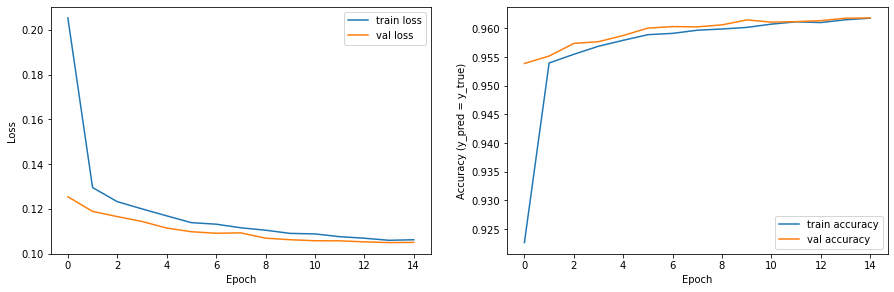

In [63]:
# plot loss vs epoch
plt.figure(figsize = (15,10))
axes = plt.subplot(2, 2, 1)
axes.plot(history.history['loss'], label = 'train loss')
axes.plot(history.history['val_loss'], label = 'val loss')
axes.legend(loc = "upper right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Loss')

# plot accuracy vs epoch
axes = plt.subplot(2, 2, 2)
axes.plot(history.history['accuracy'], label = 'train accuracy')
axes.plot(history.history['val_accuracy'], label = 'val accuracy')
axes.legend(loc = "lower right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Accuracy (y_pred = y_true)')

## Partition the test set into sig/bkg sets

In [64]:
# test set
test_sig_number = np.count_nonzero(Y_test)
test_bkg_number = np.count_nonzero(Y_test == 0)

X_test_sig = np.zeros((test_sig_number,X_test.shape[1]))
X_test_bkg = np.zeros((test_bkg_number,X_test.shape[1]))

j = 0
k = 0
for i in range(Y_test.shape[0]):
    if Y_test[i,0] == 1:
        X_test_sig[j,:] = X_test[i,:]
        j = j + 1
    else:
        X_test_bkg[k,:] = X_test[i,:]
        k = k + 1

# train+val set
train_val_sig_number = np.count_nonzero(Y_train_val)
train_val_bkg_number = np.count_nonzero(Y_train_val == 0)

X_train_val_sig = np.zeros((train_val_sig_number,X_train_val.shape[1]))
X_train_val_bkg = np.zeros((train_val_bkg_number,X_train_val.shape[1]))

j = 0
k = 0
for i in range(Y_train_val.shape[0]):
    if Y_train_val[i,0] == 1:
        X_train_val_sig[j,:] = X_train_val[i,:]
        j = j + 1
    else:
        X_train_val_bkg[k,:] = X_train_val[i,:]
        k = k + 1

## Test set performance plots

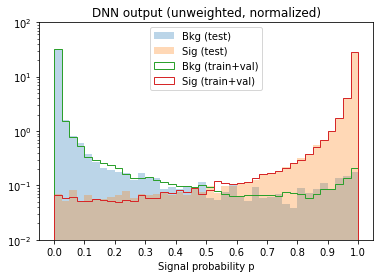

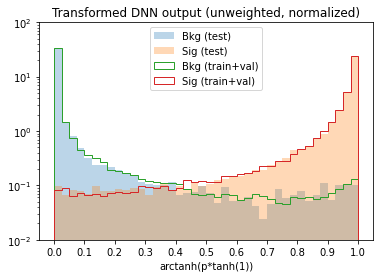

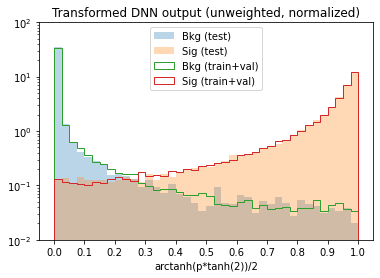

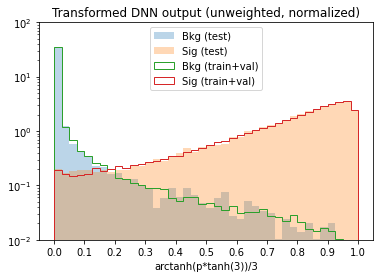

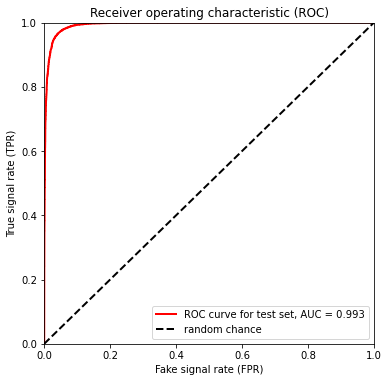

Test loss, test accuracy: [0.10132872220201102, 0.9622918367385864]


In [67]:
#pyplot.hist(model.predict(X_test_bkg), density = 1, range = (0.0, 1.0), bins = 40, alpha = 0.3, label = 'Bkg (test)')
pyplot.hist(model.predict(X_test_bkg), density = 1, range = (0.0, 1.0), bins = 40, alpha = 0.3, label = 'Bkg (test)', log = True)
pyplot.hist(model.predict(X_test_sig), density = 1, range = (0.0, 1.0), bins = 40, alpha = 0.3, label = 'Sig (test)')
pyplot.hist(model.predict(X_train_val_bkg), density = 1, range = (0.0, 1.0), bins = 40, label = 'Bkg (train+val)', histtype = 'step')
pyplot.hist(model.predict(X_train_val_sig), density = 1, range = (0.0, 1.0), bins = 40, label = 'Sig (train+val)', histtype = 'step')
pyplot.legend(loc = 'upper center')
pyplot.title('DNN output (unweighted, normalized)')
pyplot.xlabel('Signal probability p')
pyplot.xticks(np.arange(0, 1.1, step = 0.1))
pyplot.ylim(1e-2,1e2)
pyplot.show()

#pyplot.hist(np.arctanh(model.predict(X_test_bkg)*np.tanh(1)), density = 1, range = (0.0, 1), bins = 40, alpha = 0.3, label = 'Bkg (test)')
pyplot.hist(np.arctanh(model.predict(X_test_bkg)*np.tanh(1)), density = 1, range = (0.0, 1), bins = 40, alpha = 0.3, label = 'Bkg (test)', log = True)
pyplot.hist(np.arctanh(model.predict(X_test_sig)*np.tanh(1)), density = 1, range = (0.0, 1), bins = 40, alpha = 0.3, label = 'Sig (test)')
pyplot.hist(np.arctanh(model.predict(X_train_val_bkg)*np.tanh(1)), density = 1, range = (0.0, 1), bins = 40, label = 'Bkg (train+val)', histtype = 'step')
pyplot.hist(np.arctanh(model.predict(X_train_val_sig)*np.tanh(1)), density = 1, range = (0.0, 1), bins = 40, label = 'Sig (train+val)', histtype = 'step')
pyplot.legend(loc = 'upper center')
pyplot.title('Transformed DNN output (unweighted, normalized)')
pyplot.xlabel('arctanh(p*tanh(1))')
pyplot.xticks(np.arange(0, 1.1, step = 0.1))
pyplot.ylim(1e-2,1e2)
pyplot.show()

#pyplot.hist(np.arctanh(model.predict(X_test_bkg)*np.tanh(2))/2, density = 1, range = (0.0, 1), bins = 40, alpha = 0.3, label = 'Bkg (test)')
pyplot.hist(np.arctanh(model.predict(X_test_bkg)*np.tanh(2))/2, density = 1, range = (0.0, 1), bins = 40, alpha = 0.3, label = 'Bkg (test)', log = True)
pyplot.hist(np.arctanh(model.predict(X_test_sig)*np.tanh(2))/2, density = 1, range = (0.0, 1), bins = 40, alpha = 0.3, label = 'Sig (test)')
pyplot.hist(np.arctanh(model.predict(X_train_val_bkg)*np.tanh(2))/2, density = 1, range = (0.0, 1), bins = 40, label = 'Bkg (train+val)', histtype = 'step')
pyplot.hist(np.arctanh(model.predict(X_train_val_sig)*np.tanh(2))/2, density = 1, range = (0.0, 1), bins = 40, label = 'Sig (train+val)', histtype = 'step')
pyplot.legend(loc = 'upper center')
pyplot.title('Transformed DNN output (unweighted, normalized)')
pyplot.xlabel('arctanh(p*tanh(2))/2')
pyplot.xticks(np.arange(0, 1.1, step = 0.1))
pyplot.ylim(1e-2,1e2)
pyplot.show()

#pyplot.hist(np.arctanh(model.predict(X_test_bkg)*np.tanh(3))/3, density = 1, range = (0.0, 1), bins = 40, alpha = 0.3, label = 'Bkg (test)')
pyplot.hist(np.arctanh(model.predict(X_test_bkg)*np.tanh(3))/3, density = 1, range = (0.0, 1), bins = 40, alpha = 0.3, label = 'Bkg (test)', log = True)
pyplot.hist(np.arctanh(model.predict(X_test_sig)*np.tanh(3))/3, density = 1, range = (0.0, 1), bins = 40, alpha = 0.3, label = 'Sig (test)')
pyplot.hist(np.arctanh(model.predict(X_train_val_bkg)*np.tanh(3))/3, density = 1, range = (0.0, 1), bins = 40, label = 'Bkg (train+val)', histtype = 'step')
pyplot.hist(np.arctanh(model.predict(X_train_val_sig)*np.tanh(3))/3, density = 1, range = (0.0, 1), bins = 40, label = 'Sig (train+val)', histtype = 'step')
pyplot.legend(loc = 'upper center')
pyplot.title('Transformed DNN output (unweighted, normalized)')
pyplot.xlabel('arctanh(p*tanh(3))/3')
pyplot.xticks(np.arange(0, 1.1, step = 0.1))
pyplot.ylim(1e-2,1e2)
pyplot.show()

# Plot ROC
plt.figure(figsize = (13,13))
Y_predict = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(Y_test, Y_predict)
roc_auc = auc(fpr, tpr)
axes = plt.subplot(2, 2, 1)
axes.plot(fpr, tpr, lw = 2, color = 'red', label = 'ROC curve for test set, AUC = %.3f' % (roc_auc))
axes.plot([0, 1], [0, 1], linestyle = '--', lw = 2, color = 'black', label = 'random chance')
axes.set_xlim([0, 1.0])
axes.set_ylim([0, 1.0])
axes.set_xlabel('Fake signal rate (FPR)')
axes.set_ylabel('True signal rate (TPR)')
axes.set_title('Receiver operating characteristic (ROC)')
axes.legend(loc = "lower right")
plt.show()

results = model.evaluate(X_test, Y_test, verbose = 0, batch_size = 256)
print("Test loss, test accuracy:", results)

## Save trained model

In [69]:
joblib.dump(scaler, 'trained_models/mt_scaler.gz')
model.save('trained_models/mt_model')

## Load saved model

In [ ]:
savedscaler = joblib.load('trained_models/mt_scaler.gz')
savedmodel = keras.models.load_model('trained_models/mt_model')
savedmodel.summary()

# Write model prediction to root files

## Load all root files one by one

In [70]:
from root_numpy import array2root

########### 2018
infolder18 = 'root_raw/mt18_raw/'
outfolder18 = 'root_outputs/mt18_outputs/'

inpaths18 = ['DY.root', 'DY1.root', 'DY2.root', 'DY3.root', 'DY4.root'\
         , 'GGHTT.root', 'GGHWW.root', 'GGZHLLTT.root', 'GGZHNNTT.root'\
         , 'GGZHQQTT.root', 'GGZHWW.root', 'ST_tW_antitop.root'\
         , 'ST_tW_top.root', 'ST_t_antitop.root', 'ST_t_top.root'\
         , 'TTTo2L2Nu.root', 'TTToHadronic.root', 'TTToSemiLeptonic.root', 'VBFHTT.root', 'VBFHWW.root', 'VV2L2Nu.root'\
         , 'WZ2L2Q.root', 'WZ3LNu.root', 'WminusHTT.root', 'WminusHWW.root'\
         , 'WplusHTT.root', 'WplusHWW.root', 'ZHTT.root', 'ZHWW.root'\
         , 'ZZ2L2Q.root', 'ZZ4L.root', 'data_obs.root', 'embedded.root'\
         , 'ggH_bbtt12.root', 'ggH_bbtt20.root', 'ggH_bbtt30.root', 'ggH_bbtt40.root'\
         , 'ggH_bbtt50.root', 'ggH_bbtt60.root', 'ttHnonbb.root'\
         , 'vbf_bbtt12.root', 'vbf_bbtt20.root', 'vbf_bbtt30.root', 'vbf_bbtt40.root'\
         , 'vbf_bbtt50.root', 'vbf_bbtt60.root']

outpaths18 = ['DY.root', 'DY1.root', 'DY2.root', 'DY3.root', 'DY4.root'\
         , 'GGHTT.root', 'GGHWW.root', 'GGZHLLTT.root', 'GGZHNNTT.root'\
         , 'GGZHQQTT.root', 'GGZHWW.root', 'ST_tW_antitop.root'\
         , 'ST_tW_top.root', 'ST_t_antitop.root', 'ST_t_top.root'\
         , 'TTTo2L2Nu.root', 'TTToHadronic.root', 'TTToSemiLeptonic.root', 'VBFHTT.root', 'VBFHWW.root', 'VV2L2Nu.root'\
         , 'WZ2L2Q.root', 'WZ3LNu.root', 'WminusHTT.root', 'WminusHWW.root'\
         , 'WplusHTT.root', 'WplusHWW.root', 'ZHTT.root', 'ZHWW.root'\
         , 'ZZ2L2Q.root', 'ZZ4L.root', 'data_obs.root', 'embedded.root'\
         , 'gghbbtt12.root', 'gghbbtt20.root', 'gghbbtt30.root', 'gghbbtt40.root'\
         , 'gghbbtt50.root', 'gghbbtt60.root', 'ttHnonbb.root'\
         , 'vbfbbtt12.root', 'vbfbbtt20.root', 'vbfbbtt30.root', 'vbfbbtt40.root'\
         , 'vbfbbtt50.root', 'vbfbbtt60.root']

for i in range(len(inpaths18)):
    inpaths18[i] = infolder18 + inpaths18[i]
    outpaths18[i] = outfolder18 + outpaths18[i]

allfiles18 = []
for i in range(len(inpaths18)):
    allfiles18.append(ROOT.RDataFrame('mutau_tree', inpaths18[i]))


for i in range(len(allfiles18)):
    allfiles18[i] = allfiles18[i].Define('mymu', mymu)\
    .Define('mytau', mytau)\
    .Define('mymet', mymet)\
    .Define('mytt', mytt)\
    .Define('myb1', myb1)\
    .Define('m_btt', m_btt)\
    .Define('m_b1mu', m_b1mu)\
    .Define('m_b1tau', m_b1tau)\
    .Define('dR_tt', dR_tt)\
    .Define('dR_b1mu', dR_b1mu)\
    .Define('dR_b1tau', dR_b1tau)\
    .Define('dR_b1tt', dR_b1tt)\
    .Define('tt_pt', tt_pt)\
    .Define('tt_eta', tt_eta)\
    .Define('mT_mu', mT_mu)\
    .Define('mT_tau', mT_tau)\
    .Define('mT_b1', mT_b1)\
    .Define('norm_zeta', norm_zeta)\
    .Define('x_zeta', x_zeta)\
    .Define('y_zeta', y_zeta)\
    .Define('p_zeta_mis', p_zeta_mis)\
    .Define('pzeta_vis', pzeta_vis)\
    .Define('Dzeta', Dzeta)

########### 2017
infolder17 = 'root_raw/mt17_raw/'
outfolder17 = 'root_outputs/mt17_outputs/'

inpaths17 = ['DY.root', 'DY1.root', 'DY2.root', 'DY3.root', 'DY4.root'\
         , 'GGHTT.root', 'GGHWW.root', 'GGZHLLTT.root', 'GGZHNNTT.root'\
         , 'GGZHQQTT.root', 'GGZHWW.root', 'ST_tW_antitop.root'\
         , 'ST_tW_top.root', 'ST_t_antitop.root', 'ST_t_top.root'\
         , 'TTTo2L2Nu.root', 'TTToHadronic.root', 'TTToSemiLeptonic.root', 'VBFHTT.root', 'VBFHWW.root', 'VV2L2Nu.root'\
         , 'WZ2L2Q.root', 'WZ3L1Nu.root', 'WminusHTT.root', 'WminusHWW.root'\
         , 'WplusHTT.root', 'WplusHWW.root', 'ZHTT.root', 'ZHWW.root'\
         , 'ZZ2L2Q.root', 'ZZ4L.root', 'data_obs.root', 'embedded.root'\
         , 'ggH_bbtt12.root', 'ggH_bbtt20.root', 'ggH_bbtt30.root', 'ggH_bbtt40.root'\
         , 'ggH_bbtt50.root', 'ggH_bbtt60.root', 'ttHnonbb.root'\
         , 'vbf_bbtt12.root', 'vbf_bbtt20.root', 'vbf_bbtt30.root', 'vbf_bbtt40.root'\
         , 'vbf_bbtt50.root', 'vbf_bbtt60.root']

outpaths17 = ['DY.root', 'DY1.root', 'DY2.root', 'DY3.root', 'DY4.root'\
         , 'GGHTT.root', 'GGHWW.root', 'GGZHLLTT.root', 'GGZHNNTT.root'\
         , 'GGZHQQTT.root', 'GGZHWW.root', 'ST_tW_antitop.root'\
         , 'ST_tW_top.root', 'ST_t_antitop.root', 'ST_t_top.root'\
         , 'TTTo2L2Nu.root', 'TTToHadronic.root', 'TTToSemiLeptonic.root', 'VBFHTT.root', 'VBFHWW.root', 'VV2L2Nu.root'\
         , 'WZ2L2Q.root', 'WZ3L1Nu.root', 'WminusHTT.root', 'WminusHWW.root'\
         , 'WplusHTT.root', 'WplusHWW.root', 'ZHTT.root', 'ZHWW.root'\
         , 'ZZ2L2Q.root', 'ZZ4L.root', 'data_obs.root', 'embedded.root'\
         , 'gghbbtt12.root', 'gghbbtt20.root', 'gghbbtt30.root', 'gghbbtt40.root'\
         , 'gghbbtt50.root', 'gghbbtt60.root', 'ttHnonbb.root'\
         , 'vbfbbtt12.root', 'vbfbbtt20.root', 'vbfbbtt30.root', 'vbfbbtt40.root'\
         , 'vbfbbtt50.root', 'vbfbbtt60.root']

for i in range(len(inpaths17)):
    inpaths17[i] = infolder17 + inpaths17[i]
    outpaths17[i] = outfolder17 + outpaths17[i]

allfiles17 = []
for i in range(len(inpaths17)):
    allfiles17.append(ROOT.RDataFrame('mutau_tree', inpaths17[i]))


for i in range(len(allfiles17)):
    allfiles17[i] = allfiles17[i].Define('mymu', mymu)\
    .Define('mytau', mytau)\
    .Define('mymet', mymet)\
    .Define('mytt', mytt)\
    .Define('myb1', myb1)\
    .Define('m_btt', m_btt)\
    .Define('m_b1mu', m_b1mu)\
    .Define('m_b1tau', m_b1tau)\
    .Define('dR_tt', dR_tt)\
    .Define('dR_b1mu', dR_b1mu)\
    .Define('dR_b1tau', dR_b1tau)\
    .Define('dR_b1tt', dR_b1tt)\
    .Define('tt_pt', tt_pt)\
    .Define('tt_eta', tt_eta)\
    .Define('mT_mu', mT_mu)\
    .Define('mT_tau', mT_tau)\
    .Define('mT_b1', mT_b1)\
    .Define('norm_zeta', norm_zeta)\
    .Define('x_zeta', x_zeta)\
    .Define('y_zeta', y_zeta)\
    .Define('p_zeta_mis', p_zeta_mis)\
    .Define('pzeta_vis', pzeta_vis)\
    .Define('Dzeta', Dzeta)

########### 2016
infolder16 = 'root_raw/mt16_raw/'
outfolder16 = 'root_outputs/mt16_outputs/'

inpaths16 = ['DY.root', 'DY1.root', 'DY2.root', 'DY3.root', 'DY4.root'\
         , 'GGHTT.root', 'GGHWW.root', 'GGZHLLTT.root', 'GGZHNNTT.root'\
         , 'GGZHQQTT.root', 'GGZHWW.root', 'ST_tW_antitop.root'\
         , 'ST_tW_top.root', 'ST_t_antitop.root', 'ST_t_top.root'\
         , 'TT.root', 'VBFHTT.root', 'VBFHWW.root', 'VV2L2Nu.root'\
         , 'WZ2L2Q.root', 'WZ3L1Nu.root', 'WminusHTT.root', 'WminusHWW.root'\
         , 'WplusHTT.root', 'WplusHWW.root', 'ZHTT.root', 'ZHWW.root'\
         , 'ZZ2L2Q.root', 'ZZ4L.root', 'data_obs.root', 'embedded.root'\
         , 'ggH_bbtt15.root', 'ggH_bbtt20.root', 'ggH_bbtt25.root', 'ggH_bbtt30.root', 'ggH_bbtt35.root', 'ggH_bbtt40.root'\
         , 'ggH_bbtt45.root', 'ggH_bbtt50.root', 'ggH_bbtt55.root', 'ggH_bbtt60.root', 'ttHnonbb.root'\
         , 'vbf_bbtt15.root', 'vbf_bbtt20.root', 'vbf_bbtt25.root', 'vbf_bbtt30.root', 'vbf_bbtt35.root', 'vbf_bbtt40.root'\
         , 'vbf_bbtt45.root', 'vbf_bbtt50.root', 'vbf_bbtt55.root', 'vbf_bbtt60.root']

outpaths16 = ['DY.root', 'DY1.root', 'DY2.root', 'DY3.root', 'DY4.root'\
         , 'GGHTT.root', 'GGHWW.root', 'GGZHLLTT.root', 'GGZHNNTT.root'\
         , 'GGZHQQTT.root', 'GGZHWW.root', 'ST_tW_antitop.root'\
         , 'ST_tW_top.root', 'ST_t_antitop.root', 'ST_t_top.root'\
         , 'TT.root', 'VBFHTT.root', 'VBFHWW.root', 'VV2L2Nu.root'\
         , 'WZ2L2Q.root', 'WZ3L1Nu.root', 'WminusHTT.root', 'WminusHWW.root'\
         , 'WplusHTT.root', 'WplusHWW.root', 'ZHTT.root', 'ZHWW.root'\
         , 'ZZ2L2Q.root', 'ZZ4L.root', 'data_obs.root', 'embedded.root'\
         , 'ggH_bbtt15.root', 'ggH_bbtt20.root', 'ggH_bbtt25.root', 'ggH_bbtt30.root', 'ggH_bbtt35.root', 'ggH_bbtt40.root'\
         , 'ggH_bbtt45.root', 'ggH_bbtt50.root', 'ggH_bbtt55.root', 'ggH_bbtt60.root', 'ttHnonbb.root'\
         , 'vbf_bbtt15.root', 'vbf_bbtt20.root', 'vbf_bbtt25.root', 'vbf_bbtt30.root', 'vbf_bbtt35.root', 'vbf_bbtt40.root'\
         , 'vbf_bbtt45.root', 'vbf_bbtt50.root', 'vbf_bbtt55.root', 'vbf_bbtt60.root']

for i in range(len(inpaths16)):
    inpaths16[i] = infolder16 + inpaths16[i]
    outpaths16[i] = outfolder16 + outpaths16[i]

allfiles16 = []
for i in range(len(inpaths16)):
    allfiles16.append(ROOT.RDataFrame('mutau_tree', inpaths16[i]))


for i in range(len(allfiles16)):
    allfiles16[i] = allfiles16[i].Define('mymu', mymu)\
    .Define('mytau', mytau)\
    .Define('mymet', mymet)\
    .Define('mytt', mytt)\
    .Define('myb1', myb1)\
    .Define('m_btt', m_btt)\
    .Define('m_b1mu', m_b1mu)\
    .Define('m_b1tau', m_b1tau)\
    .Define('dR_tt', dR_tt)\
    .Define('dR_b1mu', dR_b1mu)\
    .Define('dR_b1tau', dR_b1tau)\
    .Define('dR_b1tt', dR_b1tt)\
    .Define('tt_pt', tt_pt)\
    .Define('tt_eta', tt_eta)\
    .Define('mT_mu', mT_mu)\
    .Define('mT_tau', mT_tau)\
    .Define('mT_b1', mT_b1)\
    .Define('norm_zeta', norm_zeta)\
    .Define('x_zeta', x_zeta)\
    .Define('y_zeta', y_zeta)\
    .Define('p_zeta_mis', p_zeta_mis)\
    .Define('pzeta_vis', pzeta_vis)\
    .Define('Dzeta', Dzeta)

## Data pre-processing

In [71]:
######### 2018
for i in range(len(allfiles18)):
    allfiles18[i] = pd.DataFrame(allfiles18[i].AsNumpy(feature_list))
    allfiles18[i] = allfiles18[i].values
    allfiles18[i] = scaler.transform(allfiles18[i])
    print(inpaths18[i])

root_raw/mt18_raw/DY.root
root_raw/mt18_raw/DY1.root
root_raw/mt18_raw/DY2.root
root_raw/mt18_raw/DY3.root
root_raw/mt18_raw/DY4.root
root_raw/mt18_raw/GGHTT.root
root_raw/mt18_raw/GGHWW.root
root_raw/mt18_raw/GGZHLLTT.root
root_raw/mt18_raw/GGZHNNTT.root
root_raw/mt18_raw/GGZHQQTT.root
root_raw/mt18_raw/GGZHWW.root
root_raw/mt18_raw/ST_tW_antitop.root
root_raw/mt18_raw/ST_tW_top.root
root_raw/mt18_raw/ST_t_antitop.root
root_raw/mt18_raw/ST_t_top.root
root_raw/mt18_raw/TTTo2L2Nu.root
root_raw/mt18_raw/TTToHadronic.root
root_raw/mt18_raw/TTToSemiLeptonic.root
root_raw/mt18_raw/VBFHTT.root
root_raw/mt18_raw/VBFHWW.root
root_raw/mt18_raw/VV2L2Nu.root
root_raw/mt18_raw/WZ2L2Q.root
root_raw/mt18_raw/WZ3LNu.root
root_raw/mt18_raw/WminusHTT.root
root_raw/mt18_raw/WminusHWW.root
root_raw/mt18_raw/WplusHTT.root
root_raw/mt18_raw/WplusHWW.root
root_raw/mt18_raw/ZHTT.root
root_raw/mt18_raw/ZHWW.root
root_raw/mt18_raw/ZZ2L2Q.root
root_raw/mt18_raw/ZZ4L.root
root_raw/mt18_raw/data_obs.root
root_raw

In [73]:
######### 2017
for i in range(len(allfiles17)):
    allfiles17[i] = pd.DataFrame(allfiles17[i].AsNumpy(feature_list))
    allfiles17[i] = allfiles17[i].values
    allfiles17[i] = scaler.transform(allfiles17[i])
    print(inpaths17[i])

root_raw/mt17_raw/DY.root
root_raw/mt17_raw/DY1.root
root_raw/mt17_raw/DY2.root
root_raw/mt17_raw/DY3.root
root_raw/mt17_raw/DY4.root
root_raw/mt17_raw/GGHTT.root
root_raw/mt17_raw/GGHWW.root
root_raw/mt17_raw/GGZHLLTT.root
root_raw/mt17_raw/GGZHNNTT.root
root_raw/mt17_raw/GGZHQQTT.root
root_raw/mt17_raw/GGZHWW.root
root_raw/mt17_raw/ST_tW_antitop.root
root_raw/mt17_raw/ST_tW_top.root
root_raw/mt17_raw/ST_t_antitop.root
root_raw/mt17_raw/ST_t_top.root
root_raw/mt17_raw/TTTo2L2Nu.root
root_raw/mt17_raw/TTToHadronic.root
root_raw/mt17_raw/TTToSemiLeptonic.root
root_raw/mt17_raw/VBFHTT.root
root_raw/mt17_raw/VBFHWW.root
root_raw/mt17_raw/VV2L2Nu.root
root_raw/mt17_raw/WZ2L2Q.root
root_raw/mt17_raw/WZ3L1Nu.root
root_raw/mt17_raw/WminusHTT.root
root_raw/mt17_raw/WminusHWW.root
root_raw/mt17_raw/WplusHTT.root
root_raw/mt17_raw/WplusHWW.root
root_raw/mt17_raw/ZHTT.root
root_raw/mt17_raw/ZHWW.root
root_raw/mt17_raw/ZZ2L2Q.root
root_raw/mt17_raw/ZZ4L.root
root_raw/mt17_raw/data_obs.root
root_ra

In [75]:
######### 2016
for i in range(len(allfiles16)):
    allfiles16[i] = pd.DataFrame(allfiles16[i].AsNumpy(feature_list))
    allfiles16[i] = allfiles16[i].values
    allfiles16[i] = scaler.transform(allfiles16[i])
    print(inpaths16[i])

root_raw/mt16_raw/DY.root
root_raw/mt16_raw/DY1.root
root_raw/mt16_raw/DY2.root
root_raw/mt16_raw/DY3.root
root_raw/mt16_raw/DY4.root
root_raw/mt16_raw/GGHTT.root
root_raw/mt16_raw/GGHWW.root
root_raw/mt16_raw/GGZHLLTT.root
root_raw/mt16_raw/GGZHNNTT.root
root_raw/mt16_raw/GGZHQQTT.root
root_raw/mt16_raw/GGZHWW.root
root_raw/mt16_raw/ST_tW_antitop.root
root_raw/mt16_raw/ST_tW_top.root
root_raw/mt16_raw/ST_t_antitop.root
root_raw/mt16_raw/ST_t_top.root
root_raw/mt16_raw/TT.root
root_raw/mt16_raw/VBFHTT.root
root_raw/mt16_raw/VBFHWW.root
root_raw/mt16_raw/VV2L2Nu.root
root_raw/mt16_raw/WZ2L2Q.root
root_raw/mt16_raw/WZ3L1Nu.root
root_raw/mt16_raw/WminusHTT.root
root_raw/mt16_raw/WminusHWW.root
root_raw/mt16_raw/WplusHTT.root
root_raw/mt16_raw/WplusHWW.root
root_raw/mt16_raw/ZHTT.root
root_raw/mt16_raw/ZHWW.root
root_raw/mt16_raw/ZZ2L2Q.root
root_raw/mt16_raw/ZZ4L.root
root_raw/mt16_raw/data_obs.root
root_raw/mt16_raw/embedded.root
root_raw/mt16_raw/ggH_bbtt15.root
root_raw/mt16_raw/ggH_bb

## Feed to NN and write outputs to root files

In [72]:
######### 2018
for i in range(len(allfiles18)):
    y_pred = model.predict(allfiles18[i])
    y_pred = np.array(y_pred, dtype = [('pred_1b', np.float32)])
    array2root(y_pred, filename = outpaths18[i], treename = 'mutau_tree_dnn', mode = 'update')
    print(outpaths18[i])

root_outputs/mt18_outputs/DY.root
root_outputs/mt18_outputs/DY1.root
root_outputs/mt18_outputs/DY2.root
root_outputs/mt18_outputs/DY3.root
root_outputs/mt18_outputs/DY4.root
root_outputs/mt18_outputs/GGHTT.root
root_outputs/mt18_outputs/GGHWW.root
root_outputs/mt18_outputs/GGZHLLTT.root
root_outputs/mt18_outputs/GGZHNNTT.root
root_outputs/mt18_outputs/GGZHQQTT.root
root_outputs/mt18_outputs/GGZHWW.root
root_outputs/mt18_outputs/ST_tW_antitop.root
root_outputs/mt18_outputs/ST_tW_top.root
root_outputs/mt18_outputs/ST_t_antitop.root
root_outputs/mt18_outputs/ST_t_top.root
root_outputs/mt18_outputs/TTTo2L2Nu.root
root_outputs/mt18_outputs/TTToHadronic.root
root_outputs/mt18_outputs/TTToSemiLeptonic.root
root_outputs/mt18_outputs/VBFHTT.root
root_outputs/mt18_outputs/VBFHWW.root
root_outputs/mt18_outputs/VV2L2Nu.root
root_outputs/mt18_outputs/WZ2L2Q.root
root_outputs/mt18_outputs/WZ3LNu.root
root_outputs/mt18_outputs/WminusHTT.root
root_outputs/mt18_outputs/WminusHWW.root
root_outputs/mt18_

In [74]:
######### 2017
for i in range(len(allfiles17)):
    y_pred = model.predict(allfiles17[i])
    y_pred = np.array(y_pred, dtype = [('pred_1b', np.float32)])
    array2root(y_pred, filename = outpaths17[i], treename = 'mutau_tree_dnn', mode = 'update')
    print(outpaths17[i])

root_outputs/mt17_outputs/DY.root
root_outputs/mt17_outputs/DY1.root
root_outputs/mt17_outputs/DY2.root
root_outputs/mt17_outputs/DY3.root
root_outputs/mt17_outputs/DY4.root
root_outputs/mt17_outputs/GGHTT.root
root_outputs/mt17_outputs/GGHWW.root
root_outputs/mt17_outputs/GGZHLLTT.root
root_outputs/mt17_outputs/GGZHNNTT.root
root_outputs/mt17_outputs/GGZHQQTT.root
root_outputs/mt17_outputs/GGZHWW.root
root_outputs/mt17_outputs/ST_tW_antitop.root
root_outputs/mt17_outputs/ST_tW_top.root
root_outputs/mt17_outputs/ST_t_antitop.root
root_outputs/mt17_outputs/ST_t_top.root
root_outputs/mt17_outputs/TTTo2L2Nu.root
root_outputs/mt17_outputs/TTToHadronic.root
root_outputs/mt17_outputs/TTToSemiLeptonic.root
root_outputs/mt17_outputs/VBFHTT.root
root_outputs/mt17_outputs/VBFHWW.root
root_outputs/mt17_outputs/VV2L2Nu.root
root_outputs/mt17_outputs/WZ2L2Q.root
root_outputs/mt17_outputs/WZ3L1Nu.root
root_outputs/mt17_outputs/WminusHTT.root
root_outputs/mt17_outputs/WminusHWW.root
root_outputs/mt17

In [76]:
######### 2016
for i in range(len(allfiles16)):
    y_pred = model.predict(allfiles16[i])
    y_pred = np.array(y_pred, dtype = [('pred_1b', np.float32)])
    array2root(y_pred, filename = outpaths16[i], treename = 'mutau_tree_dnn', mode = 'update')
    print(outpaths16[i])

root_outputs/mt16_outputs/DY.root
root_outputs/mt16_outputs/DY1.root
root_outputs/mt16_outputs/DY2.root
root_outputs/mt16_outputs/DY3.root
root_outputs/mt16_outputs/DY4.root
root_outputs/mt16_outputs/GGHTT.root
root_outputs/mt16_outputs/GGHWW.root
root_outputs/mt16_outputs/GGZHLLTT.root
root_outputs/mt16_outputs/GGZHNNTT.root
root_outputs/mt16_outputs/GGZHQQTT.root
root_outputs/mt16_outputs/GGZHWW.root
root_outputs/mt16_outputs/ST_tW_antitop.root
root_outputs/mt16_outputs/ST_tW_top.root
root_outputs/mt16_outputs/ST_t_antitop.root
root_outputs/mt16_outputs/ST_t_top.root
root_outputs/mt16_outputs/TT.root
root_outputs/mt16_outputs/VBFHTT.root
root_outputs/mt16_outputs/VBFHWW.root
root_outputs/mt16_outputs/VV2L2Nu.root
root_outputs/mt16_outputs/WZ2L2Q.root
root_outputs/mt16_outputs/WZ3L1Nu.root
root_outputs/mt16_outputs/WminusHTT.root
root_outputs/mt16_outputs/WminusHWW.root
root_outputs/mt16_outputs/WplusHTT.root
root_outputs/mt16_outputs/WplusHWW.root
root_outputs/mt16_outputs/ZHTT.root
